## This notebook generates the panels in Figure 5 + Figure 6

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext line_profiler
# %pdb

import os
import sys
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import pickle 
import time
import copy

from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import statsmodels.stats.multitest as mt
from scipy import stats
import seaborn as sns
import pandas as pd
import keras

from matplotlib import pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import cosmos.traces.trace_analysis_utils as utils
import cosmos.traces.classifier_utils as classifier
import cosmos.traces.decoding_utils as decoder
from cosmos.behavior.bpod_dataset import BpodDataset
from cosmos.traces.cell_plotter import CellPlotter
from cosmos.traces.cosmos_traces import CosmosTraces
import cosmos.params.trace_analyze_params as params



/home/deisseroth/venv2/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


/home/deisseroth/venv2/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Paths to files
data_dir = '/home/deisseroth/Dropbox/Projects/cosmos_data/'
# fig_save_dir = '/home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/'
fig_save_dir = '/home/deisseroth/Dropbox/Projects/cosmos/fig6/spout_prediction/'
bpod_dir = '/home/deisseroth/Dropbox/Projects/cosmos_data/behavior/'
pre_reward_interval = [1.0, 1.5]

# Datasets to process
dataset_ids = [19, 7, 11, 18]

# Colors
mouse_colors_dict = {7:['#00d2ff', 'A'], 11:['#3063A5', 'B'], 18:['#86becb', 'C'], 19:['#1aa3a3', 'D']}
spout_colors = ['orange', 'c', 'r']

Loading dataset  19
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:200
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
lick rates bin size: 0.034
Saving to:  /home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/polar_pre-reward.pdf
Saving to:  /home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/polar_post-reward.pdf
Saving to:  /home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/licks.pdf
Saving to:  /home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/20180709/cux2ai148m194_COSMOSTrainMultiBlockGNG_2/success_rate.pdf
LED trials: 201
Processing traces.
[ 22.0399507 515.9600493]
[393.84706348 347.15293652]
Loading dataset  7
(1/3) Loading trace data.
(2/3) Loading behavior data.
While loading bpod, enforcing that ntrials is:211
lick rates b

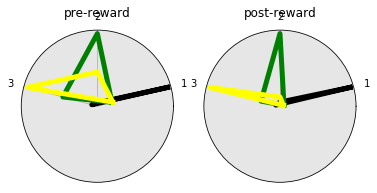

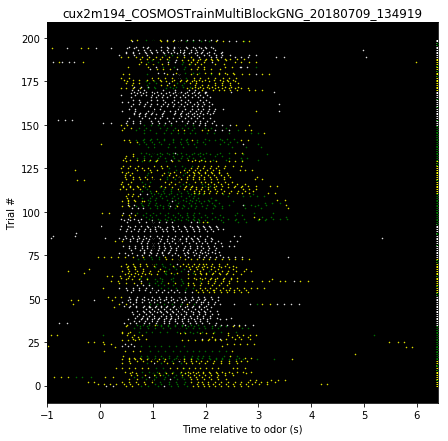

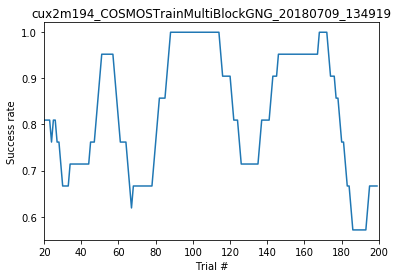

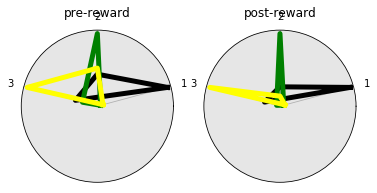

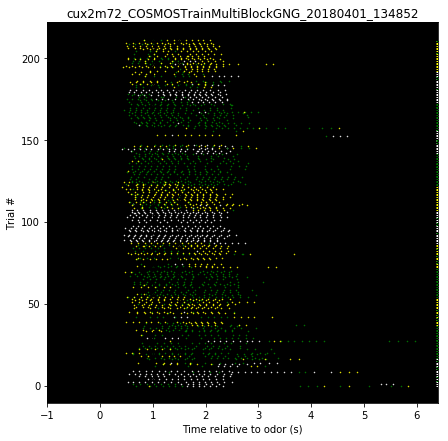

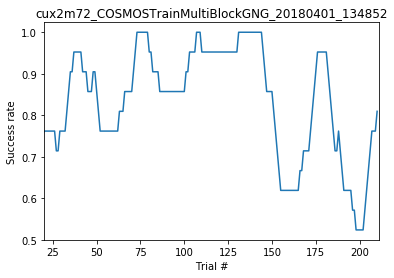

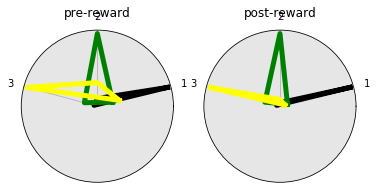

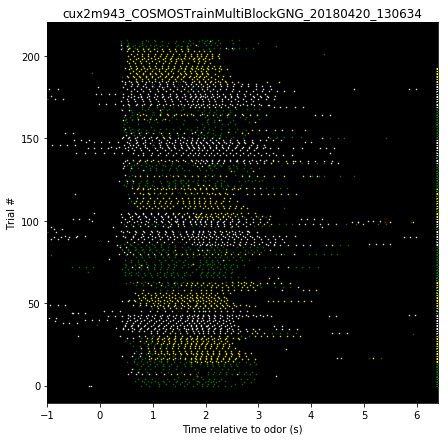

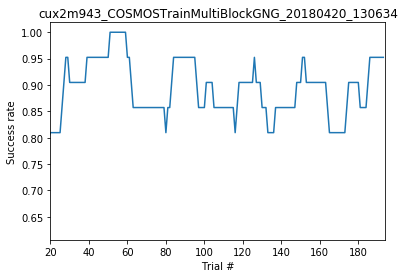

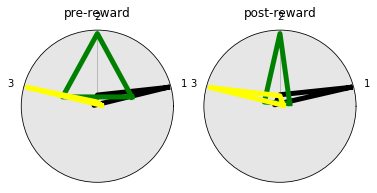

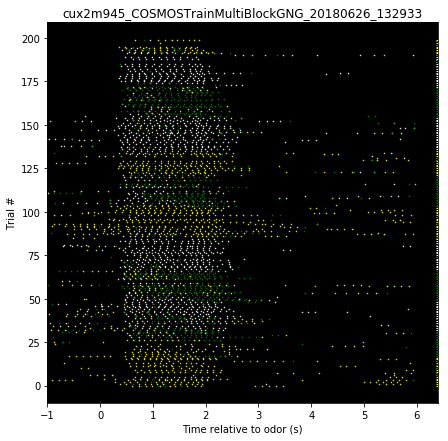

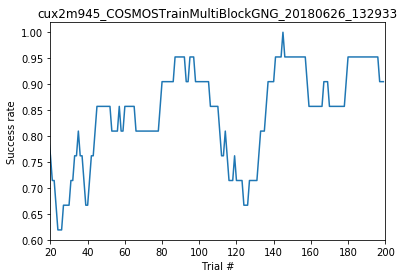

In [3]:
datasets = {}
fig_save_dir_loading = '/home/deisseroth/Dropbox/Projects/cosmos/trace_analysis/'
for dataset_id in dataset_ids:
    datasets[dataset_id] = classifier.ClassifierData(dataset_id, data_dir, fig_save_dir_loading, bpod_dir)

## Plot an example raster + confusion matrix for the figure

19


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


Selective to wrong spout; n =  0   0.0 %
19 Pre-odor licks: 6.36 %
19 Trials with any pre-odor licks: 22.5 %
7


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Selective to wrong spout; n =  0   0.0 %
7 Pre-odor licks: 0.12 %
7 Trials with any pre-odor licks: 0.47 %
11


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Selective to wrong spout; n =  0   0.0 %
11 Pre-odor licks: 6.21 %
11 Trials with any pre-odor licks: 30.41 %
18


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Selective to wrong spout; n =  0   0.0 %
18 Pre-odor licks: 10.28 %
18 Trials with any pre-odor licks: 32.0 %


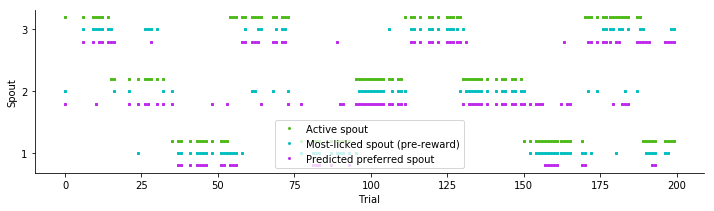

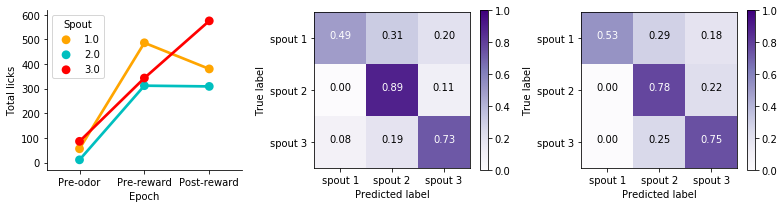

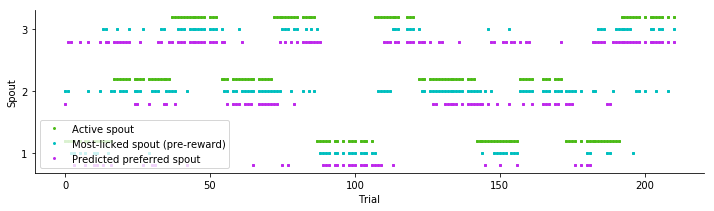

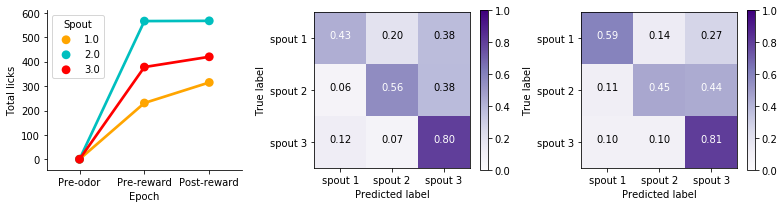

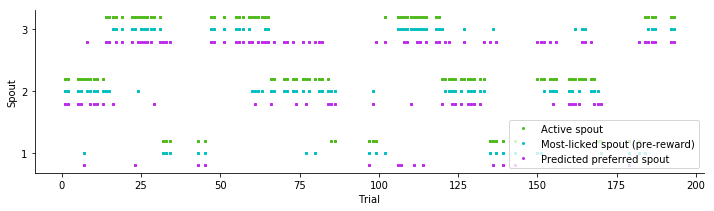

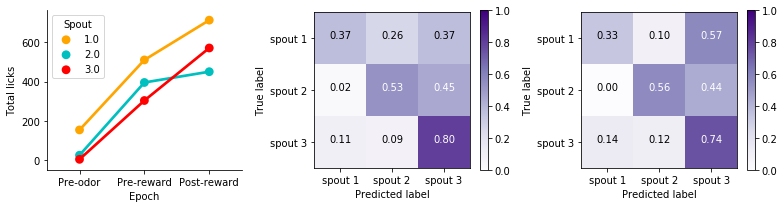

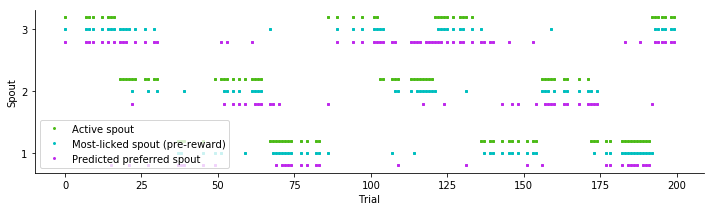

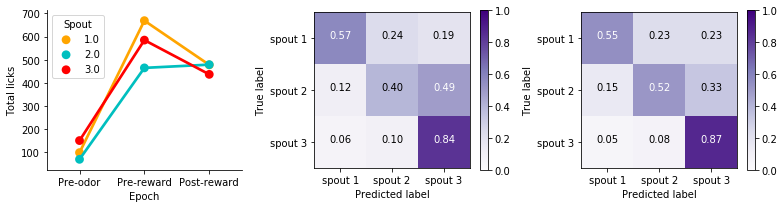

In [4]:
# Timepoints to use for model testing (training is on the full trajectory)
test_epoch = 'pre odor all'
dataset_to_save = 7 # Which dataset to use
pre_lick_percentages = [] # What % of all licks were during the pre-odor period?
pre_lick_trials = [] # What % of all trials have pre-odor licks

for dataset_id in datasets:
    print(dataset_id)

    # Train the model
    model = classifier.ClassifierModel(datasets[dataset_id], test_epoch, seed=77777)

    # Plot predictions at correct setpoint
    _ = model.predict('all')
    licks = model.plot_prediction_raster()
    save_path = os.path.join(fig_save_dir,
                             str(dataset_id) + '-spout_prediction_raster.pdf')
    plt.savefig(save_path)

    # Quantify number of pre-odor licks in a panel
    plt.figure(figsize=(11, 3))
    plt.subplot(1,3,1)
    sns.pointplot(data=licks, x='Epoch', y='Licks',
                  hue='Spout', palette=spout_colors)
    sns.despine()
    plt.ylabel('Total licks')

    # Plot normalized confusion matrix
    plt.subplot(1,3,2)
    cm = model.plot_confusion_matrix(new_figure=False)
    plt.clim([0, 1])

    plt.subplot(1,3,3)
    cx = model.plot_confusion_matrix(new_figure=False, use_position=False)
    plt.clim([0, 1])

    # What fraction of CLEAN_TRIALS are to the WRONG SPOUT?
    bad = np.where(np.where(model.favored_spout[model.clean_trials])[1] !=
                   np.where(model.spout_position[model.clean_trials])[1])[0]
    print('Selective to wrong spout; n = ', len(bad), ' ', len(bad)/model.behavior.ntrials * 100, '%')

    # print number of pre-odor licks from each mouse
    save_path = os.path.join(fig_save_dir,
                             str(dataset_id) + '-spout_prediction_total_licks.pdf')
    plt.savefig(save_path)
    
    # Display fraction of pre-odor licks
    pre = np.sum(licks.where(licks['Epoch'] == 'Pre-odor')['Licks'])
    not_pre = np.sum(licks.where(licks['Epoch'] != 'Pre-odor')['Licks'])
    prp = np.round((pre/not_pre)*100, 2)
    print(dataset_id, 'Pre-odor licks:',
          prp, '%')
    pre_lick_percentages.append(prp)
    
    # Display fraction of trials with pre-odor licks
    prt = len(np.where(model.trial_pre_odor_licks > 0)[0])/model.behavior.ntrials
    prt = np.round(prt*100, 2)
    print(dataset_id, 'Trials with any pre-odor licks:',
          prt, '%')
    pre_lick_trials.append(prt)


In [5]:
print('Pre-odor fraction of total licks', np.min(pre_lick_percentages), '-', np.max(pre_lick_percentages),
      '%, mean = ', np.mean(pre_lick_percentages))
print('Fraction of trials with pre-odor licks', np.min(pre_lick_trials), '-', np.max(pre_lick_trials),
      '%, mean = ', np.mean(pre_lick_trials))

Pre-odor fraction of total licks 0.12 - 10.28 %, mean =  5.7425
Fraction of trials with pre-odor licks 0.47 - 32.0 %, mean =  21.345


## Cross validate to choose a reasonable K to use for PLS

In [6]:
# Cross validate to choose K
ks = 8
reps = 5
seed = 22222

num_comps_df = pd.DataFrame()
for dataset_id in datasets:
    for s in range(reps):
        print('replicate', s)
        seed = seed + s
        for k in range(ks):
            model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                               k_comps=k+1, seed=seed)
            pred = model.predict('test')
            d = {'Mouse': dataset_id, 'Seed': seed,
                 'AUC': pred[1],
                 'k': k+1}
            num_comps_df = num_comps_df.append(d, ignore_index=True)

replicate 0


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


replicate 1
replicate 2
replicate 3
replicate 4
replicate 0


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


replicate 1
replicate 2
replicate 3
replicate 4
replicate 0


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


replicate 1
replicate 2
replicate 3
replicate 4
replicate 0


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


replicate 1
replicate 2
replicate 3
replicate 4


/home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/choosing-pls-k.pdf


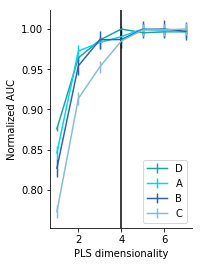

In [7]:
plt.figure(figsize=(2.54, 4))
for id_ in dataset_ids:
    line = []
    errs = []
    for k in range(ks):
        vals = num_comps_df.loc[(num_comps_df['Mouse'] == id_)
                                & (num_comps_df['k'] == k)]['AUC']
        if len(vals) == 0:
            line.append(np.nan)
            errs.append(np.nan)
        else:
            mean = np.nanmean(np.array(vals))
            err = np.nanstd(np.array(vals), ddof=1)/np.sqrt(len(vals))
            line.append(mean)
    plt.errorbar(np.arange(ks), line/np.nanmax(line), err, label=mouse_colors_dict[id_][1],
                 color=mouse_colors_dict[id_][0], lw=1.485)
    chosen_k = np.nanargmax(np.diff(line)[2:]) + 2 + 1
plt.legend()
plt.ylabel('Normalized AUC')
plt.xlabel('PLS dimensionality')
plt.axvline(classifier.DEFAULT_K_COMPONENTS, color='k')
sns.despine()
save_path = os.path.join(fig_save_dir, 'choosing-pls-k.pdf')
print(save_path)
plt.savefig(save_path)

## Plot location of sources with high discrimination ability 

In [8]:
# Critical value for statistical test + acceptable FWER
alpha = 0.05

# Other params
color = np.array([1, 0, 0, 1])
background_color=np.array([0.75, 0.75, 0.75, 0.5])
point_size = 20.79

Mouse 19 n = 930 66.38%
Mouse 7 n = 410 33.06%
Mouse 11 n = 647 59.69%
Mouse 18 n = 468 44.4%


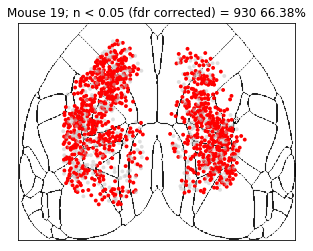

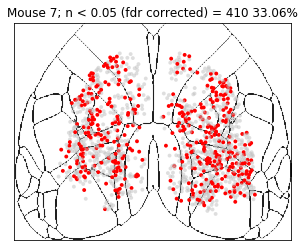

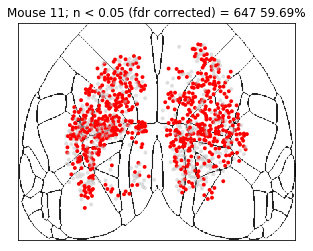

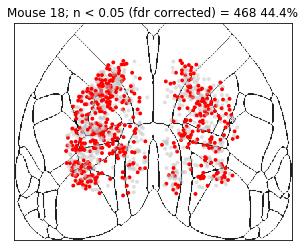

In [9]:
for id_ in datasets:
    dataset = datasets[id_]
    
    vals = mt.multipletests(dataset.p_vals, alpha=alpha, method='fdr_bh')
    p_vals = vals[1]
    idx_to_plot = np.array(np.where(p_vals < alpha)[0])
    total_idx = len(p_vals)
    all_idx = np.arange(total_idx)

    centroids = dataset.cosmos_traces.centroids
    atlas_tform = dataset.cosmos_traces.atlas_tform

    atlas_coords = utils.transform_centroids_to_atlas(centroids, atlas_tform)
    cell_ids = np.arange(atlas_coords.shape[0])
    RGBA = np.tile(np.array(color), (cell_ids.shape[0], 1))
    RGBA = np.array(RGBA, dtype='float')
    RGBA[np.setdiff1d(all_idx, idx_to_plot), :] = background_color

    plt.figure()
    prc = str(np.round(len(idx_to_plot)/total_idx*100, 2)) + '%'
    print('Mouse ' + str(id_) + ' n =', len(idx_to_plot), prc)
    utils.centroids_on_atlas(RGBA, all_idx, atlas_coords, None,
                             max_radius=15, rotate90=True)
    plt.title('Mouse ' + str(id_) + '; n < 0.05 (fdr corrected) = '
              + str(len(idx_to_plot)) + ' ' + prc)
    save_path = os.path.join(fig_save_dir,
                             'Mouse' + str(id_) + '-discrim-sources.pdf')
    plt.savefig(save_path)

## Helper functions for plotting results from subsequent analyses

In [10]:
def make_subplot(scores, x, xax):
    unshuffled = scores.loc[scores['Shuffled'] == False]
    mouse_colors = {mouse_colors_dict[key][1]: mouse_colors_dict[key][0]
                    for key in mouse_colors_dict.keys()}
    sns.pointplot(data=unshuffled, x=x, y='AUC',
                  hue='Mouse', order=xax, palette=mouse_colors)
    sns.despine()
    plt.ylim([.45, 1])
    plt.xticks(rotation=45)

    for idx, xv in enumerate(xax):
        mu = unshuffled.loc[unshuffled[x] == xv].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'r', zorder=10)

        mu = scores.loc[(scores[x] == xv) &
                        (scores['Shuffled'] == True)].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'k', zorder=10)

        mu = scores.loc[(scores[x] == xv) &
                        (scores['Shuffled'] == 'circ')].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], color=[0.5, 0.5, 0.5], zorder=10)

def make_subplot_truth(scores, x, xax):
    unshuffled = scores.loc[scores['Shuffled'] == False]
    mouse_colors = {mouse_colors_dict[key][1]: mouse_colors_dict[key][0]
                    for key in mouse_colors_dict.keys()}
    sns.pointplot(data=unshuffled, x=x, y='AUC',
                  hue='Mouse', palette=mouse_colors)
    sns.despine()
    plt.ylim([.45, 1])
    plt.xticks(rotation=45)

    for idx, xv in enumerate(xax):
        mu = unshuffled.loc[unshuffled[x] == xv].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'r', zorder=10, ms=30)

        mu = scores.loc[(scores[x] == xv) &
                        (scores['Shuffled'] == True)].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'k', zorder=10)

        mu = scores.loc[(scores[x] == xv) &
                        (scores['Shuffled'] == 'circ')].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], color=[0.5, 0.5, 0.5], zorder=10)


def make_subplot_unique(scores, x, xax):
    unshuffled = scores.loc[scores['Shuffled'] == False]
    mouse_colors = {mouse_colors_dict[key][1]: mouse_colors_dict[key][0]
                    for key in mouse_colors_dict.keys()}
    sns.pointplot(data=unshuffled, x=x, y='AUC', join=False,
                  hue='Mouse', order=xax, palette=mouse_colors)
    sns.despine()
    plt.xticks(rotation=45)

    for idx, xv in enumerate(xax):
        mu = unshuffled.loc[unshuffled[x] == xv].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'r', zorder=10)

        # Note that there are no 'circ' shuffles here because the 
        # null comparison is defined as zero unique information
        mu = scores.loc[(scores[x] == xv) &
                        (scores['Shuffled'] == True)].mean()['AUC']
        plt.plot([-.25+idx, .25+idx], [mu, mu], 'k', zorder=10)


# LUT for significance stars
def get_stars(p_value):
    """ Take in a p-value and return stars. """
    star_map=[('ns', np.inf), ('*', 0.05),
              ('**', 0.01), ('***', 0.001),
              ('****', 0.0001)]
    if np.isinf(p_value) or np.isnan(p_value):
        return 'ns'

    for label, thresh in star_map[::-1]:
        if p_value < thresh:
            return label

## (For supplement) Do we predict the active spout or the most-licked-to spout better?

In [11]:
# Process each dataset
seed = 22222
draws = 20
np.random.seed(seed)
action_scores = pd.DataFrame()
for dataset_id in dataset_ids:
    print('Dataset ' + str(dataset_id))
    for x in range(draws):
        seed = seed+x
        np.random.seed(seed + x)
        for shuffle in [True, False, 'circ']:

            # Fit the classifier/basis using all sources
            model = classifier.ClassifierModel(datasets[dataset_id], 
                                               test_epoch, seed=seed,
                                               shuffle=shuffle)

            # Save model predictions, evaluating on test data only
            predictions, auc = model.predict('test', use_spout_position=True, exclude_no_go=True)
            predictions, auc_action = model.predict('test', use_spout_position=False,
                                                    exclude_no_go=True)

            d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Truth': 'Active spout',
                 'AUC': auc, 'Shuffled': shuffle, 'Seed': seed}
            action_scores = action_scores.append(d, ignore_index=True)

            d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Truth': 'Preferred spout',
                 'AUC': auc_action, 'Shuffled': shuffle, 'Seed': seed}
            action_scores = action_scores.append(d, ignore_index=True)

Dataset 19


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


Dataset 7


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Dataset 11


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Dataset 18


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


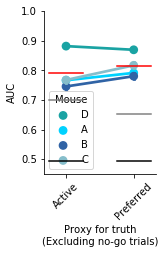

In [12]:
plt.figure(figsize=(2, 3))
ax = plt.subplot(111)
make_subplot_truth(action_scores, 'Truth', ['Active spout', 'Preferred spout'])
plt.xlabel('Proxy for truth\n(Excluding no-go trials)')
plt.ylabel('AUC')
ax.set_xticklabels(['Active','Preferred'])

save_path = os.path.join(fig_save_dir,
                         'active_preferred_auc.pdf')
plt.savefig(save_path)

In [13]:
active = []
preferred = []
mice_names = np.unique(list(action_scores['Mouse']))
for mouse in mice_names:
    active.append(np.mean(np.array(action_scores.loc[(action_scores['Mouse'] == mouse) &
                        (action_scores['Truth'] == 'Active spout')]['AUC'])))
    preferred.append(np.mean(np.array(action_scores.loc[(action_scores['Mouse'] == mouse) &
                        (action_scores['Truth'] == 'Preferred spout')]['AUC'])))
pval = scipy.stats.ttest_rel(active, preferred).pvalue
s = get_stars(pval)
print('active v. preferred; n = ', len(mice_names),
      ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

active v. preferred; n =  4 , p =  0.41517 ns ; paired t-test (fdr_bh post-hoc)


## Perform simultaneous regression and dim reduction on subsets of the data (5E)

In [14]:
# Plot each model fit
make_plots = False

# Number of random draws
draws = 20

# For reproducibility 
seed = 22222

# Define a specified list time intervals to use for inference
# Training always uses all timepoints
epochs = ['pre odor all', 'post odor all', 'all']

In [15]:
epoch_scores = pd.DataFrame()
for dataset_id in dataset_ids:
    for epoch in epochs:
        for x in range(draws):
            seed = seed + x
            np.random.seed(seed + x)
            for shuffle in [True, False, 'circ']:

                # Fit the classifier/basis using all sources (using PLSRegression)
                # The point of this panel is to compare train/test on the three different epochs
                # Obviously training happens on training trials vs. testing trials even if the
                # train and test epochs are the same.
                model = classifier.ClassifierModel(datasets[dataset_id], epoch,
                                                   seed=seed,
                                                   shuffle=shuffle)

                # Generate predictions at correct setpoint
                predictions, auc = model.predict('test')

                # Plot and save results
                if make_plots:
                    model.plot_prediction_raster()
                    plt.figure(figsize=(10, 3))
                    plt.subplot(1,2,1)
                    cm = model.plot_confusion_matrix(new_figure=False)
                    plt.title(epoch)

                d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Epoch': epoch,
                     'AUC': auc, 'Shuffled': shuffle, 'Seed': seed}
                epoch_scores = epoch_scores.append(d, ignore_index=True)

/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


In [16]:
# Compare each epoch to random using a t-test
for shuffle in [True, 'circ']:
    pvals = []
    n = []
    print('---------', 'USING SHUFFLE =', shuffle, '---------')
    for epoch in epochs:
        shuffled = []
        measured = []
        for mouse in np.unique(epoch_scores['Mouse']):

            # Mean shuffled value
            val = epoch_scores.loc[(epoch_scores['Mouse'] == mouse) &
                                  (epoch_scores['Epoch'] == epoch) &
                                  (epoch_scores['Shuffled'] == shuffle)].mean()['AUC']
            if np.isnan(val):
                continue
            shuffled.append(val)

            # Mean experimental value
            val = np.array(epoch_scores.loc[(epoch_scores['Mouse'] == mouse) &
                           (epoch_scores['Epoch'] == epoch) &
                           (epoch_scores['Shuffled'] == False)].mean()['AUC'])
            measured.append(val)

        pvalue = scipy.stats.ttest_rel(shuffled, measured).pvalue
        pvals.append(pvalue)
        n.append(len(shuffled))

    # Correct the p values and display them
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    for r, epoch, nc, pval in zip(reject, epochs, n, pvals):    
        s = get_stars(pval)
        print(epoch, ' n = ', nc, ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

--------- USING SHUFFLE = True ---------
pre odor all  n =  4 , p =  0.00132 ** ; paired t-test (fdr_bh post-hoc)
post odor all  n =  4 , p =  0.00014 *** ; paired t-test (fdr_bh post-hoc)
all  n =  4 , p =  0.00014 *** ; paired t-test (fdr_bh post-hoc)
--------- USING SHUFFLE = circ ---------
pre odor all  n =  4 , p =  0.00318 ** ; paired t-test (fdr_bh post-hoc)
post odor all  n =  4 , p =  0.00318 ** ; paired t-test (fdr_bh post-hoc)
all  n =  4 , p =  0.00318 ** ; paired t-test (fdr_bh post-hoc)


## Area dependence (5F)

In [17]:
# This is to match the other analysis
min_neurons = 75

# Number of random draws
draws = 20

# For reproducibility 
seed = 22222

# Timepoints to use
test_epoch = 'pre odor all'

# Define a specified list of regions to use
areas_ = ['MO', 'SSp', 'PTLp', 'RSP', 'VIS']

In [18]:
# Save results in a data frame
area_scores = pd.DataFrame()

# Process each dataset
print('Processing ', areas_)
for dataset_id in dataset_ids:
    CT = datasets[dataset_id].cosmos_traces
    for x in range(draws):
        seed = seed + x
        np.random.seed(seed)

        for region in CT.regions.keys():
            for shuffle in [True, False, 'circ']:
                # Get the sources in each region
                region_neurons = np.array(CT.cells_in_region[CT.regions[region]])
                if len(region_neurons) < min_neurons or region not in areas_:
                    continue

                # Find each source in the discriminability ordered list
                sx = [np.argwhere(datasets[dataset_id].p_ordering == x)[0][0]
                      for x in region_neurons]
                sorted_idx = np.argsort(sx)

                # Keep the top few
                sorted_neurons = region_neurons[sorted_idx]
                sorted_neurons = sorted_neurons[:min_neurons]

                # Fit the classifier/basis using all sources
                model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                                   cells_to_use=sorted_neurons,
                                                   seed=seed,
                                                   shuffle=shuffle)

                # Save model predictions, evaluating on test data only
                predictions, auc = model.predict('test')
                d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Area': region,
                     'AUC': auc, 'Shuffled': shuffle, 'Seed': seed}
                area_scores = area_scores.append(d, ignore_index=True)

Processing  ['MO', 'SSp', 'PTLp', 'RSP', 'VIS']


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


In [19]:
# Compare each region to random using a t-test
print('NOTE: we are only using the top', min_neurons, ' in each area here')
for shuffle in [True, 'circ']:
    print('---------', 'USING SHUFFLE =', shuffle, '---------')
    pvals = []
    for region in areas_:
        shuffled = []
        measured = []
        for mouse in np.unique(area_scores['Mouse']):

            # Mean shuffled value
            val = area_scores.loc[(area_scores['Mouse'] == mouse) &
                                  (area_scores['Area'] == region) &
                                  (area_scores['Shuffled'] == shuffle)].mean()['AUC']
            if np.isnan(val):
                continue
            shuffled.append(val)

            # Mean experimental value
            val = area_scores.loc[(area_scores['Mouse'] == mouse) &
                           (area_scores['Area'] == region) &
                           (area_scores['Shuffled'] == False)].mean()['AUC']
            measured.append(val)

        pvalue = scipy.stats.ttest_rel(shuffled, measured).pvalue
        pvals.append(pvalue)

    # Correct the p values
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    for r, region, pval in zip(reject, areas_, pvals):    
        s = get_stars(pval)
        print(region, ' n = ', len(shuffled), ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

NOTE: we are only using the top 75  in each area here
--------- USING SHUFFLE = True ---------
MO  n =  4 , p =  0.00786 ** ; paired t-test (fdr_bh post-hoc)
SSp  n =  4 , p =  0.00591 ** ; paired t-test (fdr_bh post-hoc)
PTLp  n =  4 , p =  0.03035 * ; paired t-test (fdr_bh post-hoc)
RSP  n =  4 , p =  0.00591 ** ; paired t-test (fdr_bh post-hoc)
VIS  n =  4 , p =  0.01533 * ; paired t-test (fdr_bh post-hoc)
--------- USING SHUFFLE = circ ---------
MO  n =  4 , p =  0.01872 * ; paired t-test (fdr_bh post-hoc)
SSp  n =  4 , p =  0.00901 ** ; paired t-test (fdr_bh post-hoc)
PTLp  n =  4 , p =  0.08561 ns ; paired t-test (fdr_bh post-hoc)
RSP  n =  4 , p =  0.00901 ** ; paired t-test (fdr_bh post-hoc)
VIS  n =  4 , p =  0.01568 * ; paired t-test (fdr_bh post-hoc)


## Neuron count dependence (5G)

In [20]:
# Neuron count dependence
seed = 22222

# Save results in a data frame
count_scores = pd.DataFrame()

# Timepoints to use
test_epoch = 'pre odor all'

# Define a specified list of cell counts to use
counts = [50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

# Random draws of different batches of training data
draws = 20

In [21]:
# Process each dataset
np.random.seed(seed)
for dataset_id in dataset_ids:
    print('Dataset ' + str(dataset_id))
    for x in range(draws):
        seed = seed + x
        np.random.seed(seed)
        for count in counts:
            for shuffle in [True, False, 'circ']:

                # Only use the top sources from the discriminability ordered list
                best_idx = datasets[dataset_id].p_ordering[:count]

                # Fit the classifier/basis using all sources
                model = classifier.ClassifierModel(datasets[dataset_id], 
                                                   test_epoch, seed=seed,
                                                   cells_to_use=best_idx, shuffle=shuffle)

                # Save model predictions, evaluating on TEST data only
                predictions, auc = model.predict('test')

                # Save model predictions, evaluating on TRAINING data only for comparison
                train_pred, train_auc = model.predict(model.training_trials)

                d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Neurons Used': count,
                     'AUC': auc, 'AUC train': train_auc, 'Shuffled': shuffle, 'Seed': seed}
                count_scores = count_scores.append(d, ignore_index=True)

Dataset 19


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


Dataset 7
Dataset 11
Dataset 18


In [22]:
# Compare each neuron count to 50 using paired a t-test
measured_counts = []
for count in counts:
    measured_count = []
    for mouse in np.unique(count_scores['Mouse']):

        # Experimental value for this count
        val = np.mean(np.array(count_scores.loc[(count_scores['Mouse'] == mouse) &
                       (count_scores['Neurons Used'] == count) &
                       (count_scores['Shuffled'] == False)]['AUC']))
        if np.isnan(val):
            continue
        measured_count.append(val)
    measured_counts.append(measured_count)

# Actually run the test
pvals = []
n = []
for idx, count in enumerate(measured_counts):
    pvalue = scipy.stats.ttest_rel(count, measured_counts[0]).pvalue
    pvals.append(pvalue)
    n.append(len(count))
pvals = np.array(pvals)
for pval, count in zip(pvals, counts):
    if count == 500:
        print('COMPARE 500 to 50:', get_stars(pval), count, pval)
pvals[np.isnan(pvals)] = 1
print('\n')

# Correct the p values and display them
reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
for r, count, nc, pval in zip(reject, counts, n, pvals):    
    s = get_stars(pval)
    print(count, ' n = ', nc, ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

COMPARE 500 to 50: ns 500 0.07719207439022546


50  n =  4 , p =  1.0 ns ; paired t-test (fdr_bh post-hoc)
100  n =  4 , p =  0.17233 ns ; paired t-test (fdr_bh post-hoc)
200  n =  4 , p =  0.17233 ns ; paired t-test (fdr_bh post-hoc)
300  n =  4 , p =  0.17233 ns ; paired t-test (fdr_bh post-hoc)
400  n =  4 , p =  0.17233 ns ; paired t-test (fdr_bh post-hoc)
500  n =  4 , p =  0.17233 ns ; paired t-test (fdr_bh post-hoc)
600  n =  4 , p =  0.22559 ns ; paired t-test (fdr_bh post-hoc)
700  n =  4 , p =  0.24545 ns ; paired t-test (fdr_bh post-hoc)
800  n =  4 , p =  0.33067 ns ; paired t-test (fdr_bh post-hoc)
900  n =  4 , p =  0.49533 ns ; paired t-test (fdr_bh post-hoc)
1000  n =  4 , p =  0.68983 ns ; paired t-test (fdr_bh post-hoc)


## Compute region uniqueness (in supplement)

AUC(75 sources from all areas except the current one) / AUC(75 sources from all areas)

In [23]:
# This is to match the other analysis (for motor decoding in the previous figure)
min_neurons = 75

# For reproducibility 
seed = 22222
repeats = 20

# Timepoints to use
test_epoch = 'pre odor all'

# Define a specified list of regions to use
areas = ['MO', 'SSp', 'PTLp', 'RSP', 'VIS']

In [24]:
unique_scores =  pd.DataFrame()
for x in range(repeats):
    seed = seed + x

    # Compute denominator (AUC using 75*len(areas) sources)
    all_auc = {}
    for dataset_id in dataset_ids:
        all_neurons = []
        for region in CT.regions.keys():
            # Get the sources in each region
            region_neurons = np.array(CT.cells_in_region[CT.regions[region]])
            if len(region_neurons) < min_neurons or region not in areas:
                continue

            # Find each source in the discriminability ordered list
            sx = [np.argwhere(datasets[dataset_id].p_ordering == x)[0][0]
                  for x in region_neurons]
            sorted_idx = np.argsort(sx)

            # Keep the top few
            sorted_neurons = region_neurons[sorted_idx]
            sorted_neurons = sorted_neurons[:min_neurons]
            all_neurons.append(sorted_neurons)

        all_neurons = np.concatenate(all_neurons)

        print('dataset', dataset_id, len(all_neurons)/75) # This should be 5 on each iteration

        # Fit model to 75 sources from each area jointly
        model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                           cells_to_use=all_neurons,
                                           shuffle=False, seed=seed)

        # Save model predictions, evaluating on test data only
        predictions, auc = model.predict('test')
        all_auc[dataset_id] = auc


    # Compute numerator (AUC using 75*(len(areas)-1) sources)
    # Compute denominator (AUC using 75*len(areas))
    for dataset_id in dataset_ids:
        for region in CT.regions.keys():
            all_neurons = []
            for region_ in CT.regions.keys():
                if region == region_:
                    continue

                # Get the sources in each region
                region_neurons = np.array(CT.cells_in_region[CT.regions[region_]])
                if len(region_neurons) < min_neurons or region_ not in areas:
                    continue

                # Find each source in the discriminability ordered list
                sx = [np.argwhere(datasets[dataset_id].p_ordering == x)[0][0]
                      for x in region_neurons]
                sorted_idx = np.argsort(sx)

                # Keep the top few
                sorted_neurons = region_neurons[sorted_idx]
                sorted_neurons = sorted_neurons[:min_neurons]
                all_neurons.append(sorted_neurons)

            all_neurons = np.concatenate(all_neurons)

            print('dataset', dataset_id, len(all_neurons)/75) # This should be 4 on each iteration

            # Fit model to 75 sources from each area jointly
            model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                               cells_to_use=all_neurons,
                                               shuffle=False, seed=seed)

            # Save model predictions, evaluating on test data only
            predictions, auc = model.predict('test')
            unique_auc = 1 - (auc / all_auc[dataset_id])

            d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Area': region,
                 'AUC': unique_auc, 'Shuffled': False, 'Seed': seed}
            unique_scores = unique_scores.append(d, ignore_index=True)

            d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Area': region,
             'AUC': 0, 'Shuffled': True, 'Seed': seed}
            unique_scores = unique_scores.append(d, ignore_index=True)

dataset 19 5.0


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


dataset 7 5.0
dataset 11 5.0
dataset 18 5.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 19 5.0
dataset 7 5.0
dataset 11 5.0
dataset 18 5.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 18 4.0
dataset 19 5.0
dataset 7 5.0
dataset 11 5.0
dataset 18 5.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 19 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 7 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 11 4.0
dataset 18 4.0
dataset 18 4.

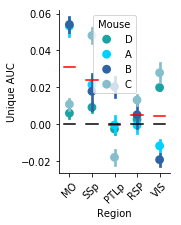

In [25]:
plt.figure(figsize=(2, 3))
make_subplot_unique(unique_scores, 'Area', areas)
plt.xlabel('Region')
plt.ylabel('Unique AUC')

save_path = os.path.join(fig_save_dir,
                         'unique_auc.pdf')
plt.savefig(save_path)

In [26]:
# Compare each region to random using a t-test
print('HERE, RANDOM CONTROL IS JUST ZEROS')
pvals = []
for region in areas:
    shuffled = []
    measured = []
    for mouse in np.unique(unique_scores['Mouse']):

        # Mean shuffled value
        val = unique_scores.loc[(unique_scores['Mouse'] == mouse) &
                                (unique_scores['Area'] == region) &
                                (unique_scores['Shuffled'] == True)].mean()['AUC']
        if np.isnan(val):
            continue
        shuffled.append(val)

        # Mean experimental values
        val = unique_scores.loc[(unique_scores['Mouse'] == mouse) &
                       (unique_scores['Area'] == region) &
                       (unique_scores['Shuffled'] == False)].mean()['AUC']
        measured.append(val)

    pvalue = scipy.stats.ttest_rel(shuffled, measured).pvalue
    pvals.append(pvalue)
print(pvals)

# Correct the p values
reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
for r, region, pval in zip(reject, areas, pvals):    
    s = get_stars(pval)
    print(region, ' n = ', len(shuffled), ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

HERE, RANDOM CONTROL IS JUST ZEROS
[0.09890575199732703, 0.06431359885201451, 0.9804999166196062, 0.18394061653022734, 0.7433063689505537]
MO  n =  4 , p =  0.24726 ns ; paired t-test (fdr_bh post-hoc)
SSp  n =  4 , p =  0.24726 ns ; paired t-test (fdr_bh post-hoc)
PTLp  n =  4 , p =  0.9805 ns ; paired t-test (fdr_bh post-hoc)
RSP  n =  4 , p =  0.30657 ns ; paired t-test (fdr_bh post-hoc)
VIS  n =  4 , p =  0.92913 ns ; paired t-test (fdr_bh post-hoc)


In [27]:
# Compare each region to random using a t-test
print('NOTE: we are only using the top', min_neurons, ' in each area here')
for shuffle in [True, 'circ']:
    print('---------', 'USING SHUFFLE =', shuffle, '---------')
    pvals = []
    for region in areas_:
        shuffled = []
        measured = []
        for mouse in np.unique(area_scores['Mouse']):

            # Mean shuffled value
            val = area_scores.loc[(area_scores['Mouse'] == mouse) &
                                  (area_scores['Area'] == region) &
                                  (area_scores['Shuffled'] == shuffle)].mean()['AUC']
            if np.isnan(val):
                continue
            shuffled.append(val)

            # Mean experimental value
            val = area_scores.loc[(area_scores['Mouse'] == mouse) &
                           (area_scores['Area'] == region) &
                           (area_scores['Shuffled'] == False)].mean()['AUC']
            measured.append(val)

        pvalue = scipy.stats.ttest_rel(shuffled, measured).pvalue
        pvals.append(pvalue)

    # Correct the p values
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    for r, region, pval in zip(reject, areas_, pvals):    
        s = get_stars(pval)
        print(region, ' n = ', len(shuffled), ', p = ', np.round(pval, 5), s + ' ; paired t-test (fdr_bh post-hoc)')

NOTE: we are only using the top 75  in each area here
--------- USING SHUFFLE = True ---------
MO  n =  4 , p =  0.00786 ** ; paired t-test (fdr_bh post-hoc)
SSp  n =  4 , p =  0.00591 ** ; paired t-test (fdr_bh post-hoc)
PTLp  n =  4 , p =  0.03035 * ; paired t-test (fdr_bh post-hoc)
RSP  n =  4 , p =  0.00591 ** ; paired t-test (fdr_bh post-hoc)
VIS  n =  4 , p =  0.01533 * ; paired t-test (fdr_bh post-hoc)
--------- USING SHUFFLE = circ ---------
MO  n =  4 , p =  0.01872 * ; paired t-test (fdr_bh post-hoc)
SSp  n =  4 , p =  0.00901 ** ; paired t-test (fdr_bh post-hoc)
PTLp  n =  4 , p =  0.08561 ns ; paired t-test (fdr_bh post-hoc)
RSP  n =  4 , p =  0.00901 ** ; paired t-test (fdr_bh post-hoc)
VIS  n =  4 , p =  0.01568 * ; paired t-test (fdr_bh post-hoc)


## Look at neural predictions on trial groups (correct, incorrect, nogo); in supplement

In [28]:
# This analysis works okay but isn't currently in the paper
from collections import defaultdict

# We don't have much data here for two related reasons:
# 1) There aren't enough error trials in the 4 mice
# 2) This requires us to use a high 'bad_cutoff' that reduces the effect size
# because then we're treating pretty good trials as incorrect trials

# So with 1 model, we don't see a significant effect but averaged across 20 models
# there is indeed a significant effect where the performance on error trials
# is slightly worse. This analysis is fairly redundant with the distance analysis performed
# later, so we're going to just show that in the text for now. But it's nice this also works.

# For this analysis, unlike the rest of the stuff in Figure 6, we're decoding the ACTIVE SPOUT.
# Otherwise, it doesn't make sense to talk about incorrect + second trials.

# Timepoints to use
test_epoch = 'pre odor all'

USE_SPOUT_POSITION = True

# Other parameters
shuffle = False
truncate = False
original_seed = 22222
reps = 20
groups = ['Go trials', 'No go trials', 'Incorrect go trials', '2nd trials']
trial_modes = ['good', 'all', 'bad', 'all']

# We have to have a fairly high "bad cutoff" here so we have enough error trials to process;
# to compute AUC correctly, we need some trials in each direction.
good_cutoff = 0.7
bad_cutoff = 0.7

# Save results in a data frame
group_scores = pd.DataFrame()
for dataset_id in datasets.keys():
    print(dataset_id)
    seed = original_seed
    for x in range(reps):
        seed = seed + x
        for shuffle in [True, False, 'circ']:
            

            # Fit the classifier/basis using all sources
            model = classifier.ClassifierModel(datasets[dataset_id], 
                                               test_epoch, seed=seed,
                                               shuffle=shuffle)

            explore = np.where(model.behavior.trial_types == 2)[0]
            go = np.where(model.behavior.trial_types == 3)[0]
            nogo = np.where(model.behavior.trial_types == 4)[0]
            second_trials = np.where(model.behavior.ind_within_block == 1)[0]

            trial_groups = defaultdict(list)
            for group, trial_mode in zip(groups, trial_modes):
                for trial in np.arange(model.behavior.ntrials):

                    if group == '2nd trials':
                        if trial not in second_trials:
                            continue
                    else:
                        if trial in explore:
                            continue

                        if (group in ['Incorrect go trials', 'Go trials']) and (trial in nogo):
                            continue

                        if (group in ['No go trials']) and trial in go:
                            continue

                    # Skip training trials
                    if trial in model.training_trials:
                        continue
                    # Get trials where most licks were towards the active spout
                    # This is importantly using all licks on the trial--not just pre-odor licks
                    # Note that the 'trial_mode' flag changes how we impose this check
                    # ie we don't check on nogo, and we want <= bad_cutoff on incorrect trials
                    selective = model.check_selectivity(trial, trial_mode, good_cutoff, bad_cutoff)
                    if not selective:
                        continue


                    # Get rid of trials with licks during the pre-odor period
                    if trial in model.pre_lick_trials:
                        continue

                    trial_groups[group].append(trial)

            # Check that once we permute the data, there's enough data towards each spout
            # Note that this process means that we might reject some replicates (instead of
            # having exactly 20 data/shuffle copies per mouse)
            bad = False
            for group in groups:

                # This finds x == 1, 3, and 4
                sp = datasets[dataset_id].behavior.spout_positions[trial_groups[group]]
                sh = np.histogram(sp, [1, 3, 4, 5])[0]

                # Make sure there is at least 1 trial to each spout
                if not np.all(sh > 0):
                    bad = True
            if bad:
                continue

            # Only use 2 trials/direction per group
            if truncate:
                for group in groups:
                    ap = []
                    for spout in model.behavior.spout_positions:
                        x = np.where(
                            model.behavior.spout_positions[trial_groups[group]] == spout)[0]
                        sp = np.array(trial_groups[group])[x]
                        sp = sp[:2]
                        ap.append(sp)
                    trial_groups[group] = np.unique(np.concatenate(ap))

            # Save model predictions, evaluating on test data only
            for group in groups:
                predictions, auc = model.predict(trial_groups[group], use_spout_position=USE_SPOUT_POSITION)

                d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Group': group,
                     'AUC': auc, 'Shuffled': shuffle, 'Seed': seed}
                group_scores = group_scores.append(d, ignore_index=True)

19


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/venv2/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


7


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


11


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


18


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


In [29]:
# Run some stats
measured_groups = []
for group in groups:
    measured_group = []
    for mouse in np.unique(group_scores['Mouse']):

        # Experimental value for this count
        val = group_scores.loc[(group_scores['Mouse'] == mouse) &
                       (group_scores['Group'] == group) &
                       (group_scores['Shuffled'] == False)].mean()['AUC']
        if np.isnan(val):
            print('skipped:', group, mouse, val)
            continue
        measured_group.append(val)
    measured_groups.append(measured_group)

In [30]:
# Paired ttest (GO vs NO GO, GO vs INCORRECT, GO vs 2ND)
p1 = stats.ttest_rel(measured_groups[0], measured_groups[1]).pvalue
p2 = stats.ttest_rel(measured_groups[0], measured_groups[2]).pvalue
p3 = stats.ttest_rel(measured_groups[0], measured_groups[3]).pvalue
print('No correction: Paired ttest (GO vs NO GO, GO vs INCORRECT, GO vs 2ND)')
print(p1, p2, p3, get_stars(p1), get_stars(p2), get_stars(p3))

# With FDR correction:
reject, tp, _, _ = mt.multipletests([p2, p3], alpha=alpha, method='fdr_bh')

print('WITH correction: Paired ttest (GO vs INCORRECT, GO vs 2ND)')
print(tp, [get_stars(p) for p in tp])

No correction: Paired ttest (GO vs NO GO, GO vs INCORRECT, GO vs 2ND)
0.2392137458826894 0.025930620074700227 0.020691322269200854 ns * *
WITH correction: Paired ttest (GO vs INCORRECT, GO vs 2ND)
[0.02593062 0.02593062] ['*', '*']


## Plot AUC (preferred spout) vs. lick-selectivity (not in paper)

In [31]:
# Number of random draws
draws = 20

# For reproducibility 
seed = 22222

# Define a specified list time intervals to use for inference
# Training always uses all timepoints
selectivity_rng = [[1, 0.8], [.8, .6], [.6, 0]]

ranges = [1, .8, .6]

In [32]:
selectivity_scores = pd.DataFrame()
for dataset_id in dataset_ids:
        print('Mouse', dataset_id)
        for x in range(draws):
            seed = seed + x
            np.random.seed(seed + x)
            for shuffle in [True, False, 'circ']:

                # Fit the classifier/basis using all sources (using PLSRegression)
                # The point of this panel is to compare train/test on the three different epochs
                # Obviously training happens on training trials vs. testing trials even if the
                # train and test epochs are the same.
                model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                                   seed=seed,
                                                   shuffle=shuffle)
                
                # Exclude training trials + pre-odor trials from evaluation
                fs = np.argmax(model.favored_spout,1)
                fs = fs+2
                fs[np.where(fs==2)[0]] = 1
                test_trials = np.setdiff1d(np.arange(model.behavior.ntrials),
                                           model.training_trials)
                test_trials = np.setdiff1d(test_trials,
                                           model.pre_lick_trials)
                
                # Get pre reward lick selectivity using one of two approaches:

                # (1) selectivity TOWARDS THE ACTIVE SPOUT
                # This is PRE-REWARD selectivity of licks
                #rng = [model.odor_on, model.reward_on]                
                #selectivity = np.array(
                #    [model.behavior.get_on_target_licks(trial, rng) for trial in test_trials])
                
                # (2) selectivity TOWARDS THE MOST-LICKED SPOUT
                rng = [model.odor_on, model.reward_on]      
                selectivity = []
                for trial in test_trials:
                    ts = fs[trial]
                    selectivity.append(model.behavior.get_on_target_licks(trial, rng, target_spout=ts))
                selectivity = np.array(selectivity)
                
                for rng in selectivity_rng:
                    
                    trials_to_use = test_trials[np.where((selectivity <= rng[0]) & (selectivity > rng[1]))[0]]
                    if len(np.unique(np.argmax(model.favored_spout[trials_to_use], 1))) != 3:
                        print('Missing trials in some directions: mouse',
                              mouse_colors_dict[dataset_id][1], rng[0])
                        continue
                    
                    #print(rng[0], len(trials_to_use))

                    # Generate predictions at correct setpoint
                    predictions, auc = model.predict(trials_to_use)
                    #print(mouse_colors_dict[dataset_id][1], np.mean(auc))
                        
                    d = {'Mouse': mouse_colors_dict[dataset_id][1], 'Range': rng[0],
                         'AUC': auc, 'Shuffled': shuffle, 'Seed': seed}
                    selectivity_scores = selectivity_scores.append(d, ignore_index=True)

Mouse 19


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')


Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 1
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 1
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 1
Missing trials in some directions: mouse D 0.8
Missing trials in some directions: mouse D 0.8
Mouse 7


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.6
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trials in some directions: mouse A 0.8
Missing trial

/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trials in some directions: mouse B 0.8
Missing trial

/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 0.8
Missing trials in some directions: mouse C 1
Missing trials in some directions: mouse C 

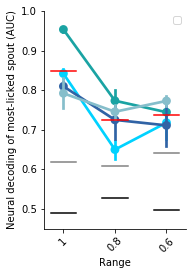

In [33]:
plt.figure(figsize=(2.54, 4))
make_subplot(selectivity_scores, 'Range', ranges)
plt.ylabel('Neural decoding of most-licked spout (AUC)')
plt.legend('')
#plt.ylim([0.25, 1])

In [34]:
# Compare each selectivity bin to the shuffle
for shuffle in [True, 'circ']:
    print('---------', 'USING SHUFFLE =', shuffle, '---------')
    pvals = []
    for range_ in ranges:
        shuffled = []
        measured = []
        for mouse in np.unique(area_scores['Mouse']):

            # Mean shuffled value
            val_sh = selectivity_scores.loc[(selectivity_scores['Mouse'] == mouse) &
                                            (selectivity_scores['Range'] == range_) &
                                            (selectivity_scores['Shuffled'] == shuffle)].mean()['AUC']
            if not np.isnan(val_sh):
                shuffled.append(val_sh)

            # Mean experimental value
            val_ex = selectivity_scores.loc[(selectivity_scores['Mouse'] == mouse) &
                                            (selectivity_scores['Range'] == range_) &
                                            (selectivity_scores['Shuffled'] == False)].mean()['AUC']
            if not np.isnan(val_ex):
                measured.append(val_ex)

        pvalue = scipy.stats.ttest_ind(shuffled, measured).pvalue
        pvals.append(pvalue)

    # Correct the p values
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    for r, range_, pval in zip(reject, ranges, pvals):    
        s = get_stars(pval)
        print(range_, ', p = ', np.round(pval, 5), s + ' ; UNpaired t-test (fdr_bh post-hoc)')

--------- USING SHUFFLE = True ---------
1 , p =  0.00026 *** ; UNpaired t-test (fdr_bh post-hoc)
0.8 , p =  0.00083 *** ; UNpaired t-test (fdr_bh post-hoc)
0.6 , p =  0.00011 *** ; UNpaired t-test (fdr_bh post-hoc)
--------- USING SHUFFLE = circ ---------
1 , p =  0.00561 ** ; UNpaired t-test (fdr_bh post-hoc)
0.8 , p =  0.02227 * ; UNpaired t-test (fdr_bh post-hoc)
0.6 , p =  0.00561 ** ; UNpaired t-test (fdr_bh post-hoc)


In [35]:
# Compare each selectivity bin to the shuffle
pvals = []
for range_ in ranges:
    shuffled = []
    measured = []
    for mouse in np.unique(area_scores['Mouse']):

        # Mean range == 1 value
        val_sh = selectivity_scores.loc[(selectivity_scores['Mouse'] == mouse) &
                                        (selectivity_scores['Range'] == 1) &
                                        (selectivity_scores['Shuffled'] == False)].mean()['AUC']
        if not np.isnan(val_sh):
            shuffled.append(val_sh)

        # Mean experimental value
        val_ex = selectivity_scores.loc[(selectivity_scores['Mouse'] == mouse) &
                                        (selectivity_scores['Range'] == range_) &
                                        (selectivity_scores['Shuffled'] == False)].mean()['AUC']
        if not np.isnan(val_ex):
            measured.append(val_ex)

    pvalue = scipy.stats.ttest_ind(shuffled, measured).pvalue
    pvals.append(pvalue)

# Correct the p values
reject, pvals, _, _ = mt.multipletests(pvals[1:], alpha=alpha, method='fdr_bh')
for r, range_, pval in zip(reject, ranges[1:], pvals):    
    s = get_stars(pval)
    print('1 vs.', range_, ', p = ', np.round(pval, 5), s + ' ; UNpaired t-test (fdr_bh post-hoc)')

1 vs. 0.8 , p =  0.03081 * ; UNpaired t-test (fdr_bh post-hoc)
1 vs. 0.6 , p =  0.03081 * ; UNpaired t-test (fdr_bh post-hoc)


## Make three subpanel plots (5E-G)

['post odor all', 'all', 'pre odor all']


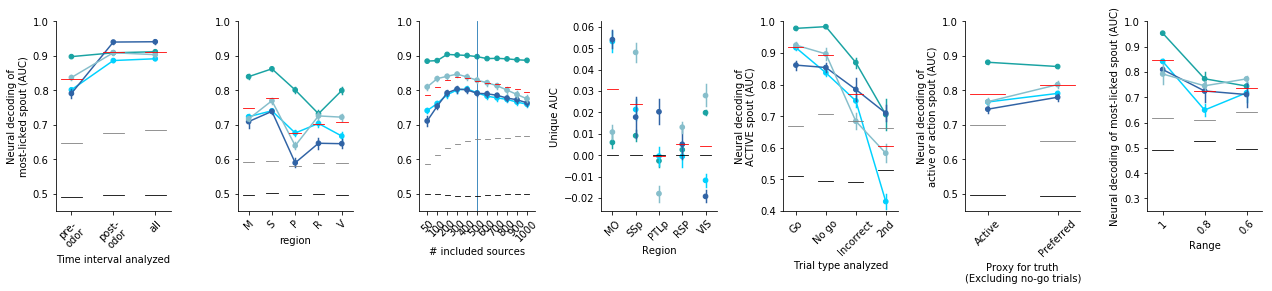

In [36]:
order = [epochs[1], epochs[2], epochs[0]]
print(order)

plt.figure(figsize=(17.78, 4))
sns.set_context(rc={"lines.linewidth": .825})

# EPOCH
ax = plt.subplot(1,7,1)
make_subplot(epoch_scores, 'Epoch', epochs)
plt.xlabel('Time interval analyzed')
plt.xticks(range(3), ['pre-\nodor', 'post-\nodor', 'all'])
ax.get_legend().remove()
plt.ylabel('Neural decoding of\nmost-licked spout (AUC)')
plt.setp(ax.collections, sizes=[point_size])

# AREAS
ax = plt.subplot(1,7,2)
make_subplot(area_scores, 'Area', areas_)
plt.xlabel('region')
plt.xticks(range(5), ['M', 'S', 'P', 'R', 'V'])
ax.get_legend().remove()
plt.ylabel('')
plt.setp(ax.collections, sizes=[point_size])

# SOURCES
ax = plt.subplot(1,7,3)
make_subplot(count_scores, 'Neurons Used', counts)
plt.xlabel('# included sources')
ax.get_legend().remove()
plt.ylabel('')
plt.setp(ax.collections, sizes=[point_size])
plt.axvline(np.where(np.array(counts) == classifier.DEFAULT_MAX_CELLS_TO_USE)[0][0])

# UNIQUE AUC
ax = plt.subplot(1,7,4)
make_subplot_unique(unique_scores, 'Area', areas_)
plt.xlabel('Region')
plt.ylabel('Unique AUC')
ax.get_legend().remove()
plt.setp(ax.collections, sizes=[point_size])

# TRIAL TYPE (> 0.7 is good, < 0.7 is bad)
ax = plt.subplot(1,7,5)
make_subplot(group_scores, 'Group', groups)
plt.xlabel('Trial type analyzed')
plt.xticks(np.arange(4),['Go','No go','Incorrect', '2nd'])
ax.get_legend().remove()
plt.ylabel('Neural decoding of\nACTIVE spout (AUC)')
plt.setp(ax.collections, sizes=[point_size])
plt.ylim([0.4, 1])

# AUC VS. ACTION 
ax = plt.subplot(1,7,6)
make_subplot_truth(action_scores, 'Truth', ['Active spout', 'Preferred spout'])
plt.xlabel('Proxy for truth\n(Excluding no-go trials)')
plt.ylabel('Neural decoding of\nactive or action spout (AUC)')
ax.set_xticklabels(['Active','Preferred'])
ax.get_legend().remove()
plt.setp(ax.collections, sizes=[point_size])

ax = plt.subplot(1,7,7)
make_subplot(selectivity_scores, 'Range', ranges)
plt.ylabel('Neural decoding of most-licked spout (AUC)')
plt.ylim([0.25, 1])
ax.get_legend().remove()
plt.setp(ax.collections, sizes=[point_size])

plt.tight_layout()

save_path = os.path.join(fig_save_dir, 'integrated_auc.pdf')
plt.savefig(save_path)

In [37]:
action_scores.to_csv('action_scores.csv')

## Lag plot (6F)

/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')
/home/deisseroth/venv2/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Skipping lag 3 on dataset 0 due to 0 licks in some direction
Skipping lag 14 on dataset 0 due to 0 licks in some direction


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Skipping lag 3 on dataset 2 due to 0 licks in some direction
Skipping lag 5 on dataset 2 due to 0 licks in some direction
Skipping lag 7 on dataset 2 due to 0 licks in some direction
Skipping lag 9 on dataset 2 due to 0 licks in some direction
Skipping lag 15 on dataset 2 due to 0 licks in some direction


/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


Skipping lag 7 on dataset 3 due to 0 licks in some direction
Skipping lag 13 on dataset 3 due to 0 licks in some direction


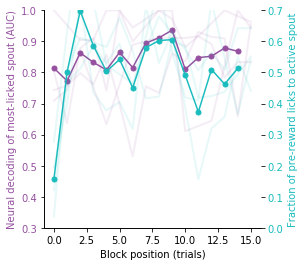

In [38]:
(lag_scores, b_auc, c_auc) = classifier.generate_lag_plot(datasets, fig_save_dir, mouse_colors_dict)

# return linewidth to default
sns.set_context(rc={"lines.linewidth": 1.5})

save_path = os.path.join(fig_save_dir, 'spout_prediction_lick_lag.pdf')
plt.savefig(save_path)

In [39]:
# Also compute stats between different lags

# BEHAVIOR
behavior_ = np.array(b_auc)
pvalue_01 = scipy.stats.ttest_rel(behavior_[:, 0], behavior_[:, 1]).pvalue
pvalue_02 = scipy.stats.ttest_rel(behavior_[:, 0], behavior_[:, 2]).pvalue
reject, pvals, _, _ = mt.multipletests([pvalue_01, pvalue_02], alpha=alpha, method='fdr_bh')

s = get_stars(pvals[0])
print('BEHAVIOR t(0) v t(1), n = ', np.shape(behavior_)[0],
      ', p = ', np.round(pvals[0], 10), s + '; paired t-test, fdr_bh')

s = get_stars(pvals[1])
print('BEHAVIOR t(0) v t(2), n = ', np.shape(behavior_)[0],
      ', p = ', np.round(pvals[1], 10), s + '; paired t-test, fdr_bh')

# NEURAL
classifier_ = np.array(c_auc)
pvalue_01 = scipy.stats.ttest_rel(classifier_[:, 0], classifier_[:, 1]).pvalue
pvalue_02 = scipy.stats.ttest_rel(classifier_[:, 0], classifier_[:, 2]).pvalue
reject, pvals, _, _ = mt.multipletests([pvalue_01, pvalue_02], alpha=alpha, method='fdr_bh')

s = get_stars(pvals[0])
print('NEURAL t(0) v t(1), n = ', np.shape(behavior_)[0],
      ', p = ', np.round(pvals[0], 10), s + '; paired t-test, fdr_bh')

s = get_stars(pvals[1])
print('NEURAL t(0) v t(2), n = ', np.shape(behavior_)[0],
      ', p = ', np.round(pvals[1], 10), s + '; paired t-test, fdr_bh')


BEHAVIOR t(0) v t(1), n =  4 , p =  0.0084404378 **; paired t-test, fdr_bh
BEHAVIOR t(0) v t(2), n =  4 , p =  0.0046334531 **; paired t-test, fdr_bh
NEURAL t(0) v t(1), n =  4 , p =  0.4306446258 ns; paired t-test, fdr_bh
NEURAL t(0) v t(2), n =  4 , p =  0.4306446258 ns; paired t-test, fdr_bh


# Figure 7

## Quantify trajectories in the pre-odor period (7D-F)

In [40]:
# For debugging classifier model stuff
#region_neurons = classifier.get_region_neurons(
#                datasets[dataset_id].cosmos_traces,
#                datasets[dataset_id].p_ordering, 'all', classifier.DEFAULT_MAX_CELLS_TO_USE)
#model = classifier.ClassifierModel(datasets[dataset_id],
#                        'all',
#                        cells_to_use=region_neurons)
#l, saved_clusters = model.measure_centroids(
#    cluster_time, traj_time,
#    min_block_trials=0,
#    exclude_pre_licks=True)

In [41]:
#[array([ 2.41881454, -0.06523944,  2.89252108, -1.75411305]),
# array([-6.27732188e-01,  1.74940802e+00, -4.01411054e+00,  2.80991705e-04]),
# #array([-2.43079545, -2.51960065,  1.39433149,  1.09565109])]
#
# ABOVE is right for saved_clusters['go']['mu'] saved_clusters['nogo']['mu']

In [42]:
# We could optionally recompute cell ordering using active spout psition vs. most-licked spout
# but do NOT do this for the figure because we want to use the same ordering/models for Fig 6 and Fig 7
#for id_ in datasets:
#    dataset = datasets[id_]
#    dataset.get_source_discriminativity(use_position=True)

In [43]:
def perform_cluster_analysis(mode, kinds, use_old):

    # Number of sources to use from each area (when doing regional analysis vs. all)
    good_cutoff = 0.70
    bad_cutoff = 0.30
    min_neurons = -1 # Use all sources from each area instead of a constant amount
    
    # Using an old model is okay for this because the values are always constant across all models
    odor_on = model.odor_on
    reward_on = model.reward_on
    dur = model.reward_on - model.odor_on
    assert dur == 44, 'Constants are changing!'

    # Interval to train clusters on
    cluster_time = [0, model.odor_on] # Use the WHOLE pre-odor period
    before = cluster_time
    during = [model.odor_on, model.reward_on] # Average over all during frames
    after = [model.reward_on, model.reward_on+dur] # Average over same duration of post-reward frames
    # before = 64 frames, during = 44 frames, after = 44 frames

    # Group up distances and compute difference distributions to plot
    ddist = pd.DataFrame()
    pdict = pd.DataFrame()
    all_distances = defaultdict(lambda: pd.DataFrame())

    for kind, traj_time in zip(kinds, [before, during, after]):
        print('----------', kind, '----------')

        # Run the initial condition comparison and make the figure
        print('Trial quality cutoffs:', good_cutoff, bad_cutoff, min_neurons)
        distances, ad = classifier.compare_initial_conditions(datasets, cluster_time, traj_time,
                                                              mouse_colors_dict,
                                                              min_neurons=min_neurons,
                                                              good_cutoff=good_cutoff,
                                                              bad_cutoff=bad_cutoff,
                                                              use_old=use_old,
                                                              mode=mode)
        all_distances[kind] = distances


        for trial_group in ['Go trials', 'No go trials', 'Incorrect go trials', '2nd trials']:
            dist_curr = distances.loc[distances['Trial group'] == trial_group]
            areas = np.unique(dist_curr['Area'])

            for area_idx, area in enumerate(areas):

                # Get the trial-to-same and trial-to-closest-different distances
                dist_area = dist_curr.loc[dist_curr['Area'] == area]
                same = np.array(dist_area.loc[
                    dist_area['Spout comparison'] == 'Same']['Distance'])
                different = np.array(dist_area.loc[
                    dist_area['Spout comparison'] == 'Different']['Distance'])
                mouse = np.array(dist_area.loc[dist_area['Spout comparison'] == 'Same']['Mouse'])

                # Verify that we're getting correctly paired data
                for c in ['Point identity', 'Point index']:
                    s = np.array(dist_area.loc[
                                 dist_area['Spout comparison'] == 'Same'][c])

                    d = np.array(dist_area.loc[
                                 dist_area['Spout comparison'] == 'Different'][c])
                    assert np.all(s == d)

                # Compute difference and store in a dataframe
                # Note that negative distances imply same is closer than different
                d = same-different
                d_random = np.random.permutation

                # Using the nonparametric test to compare the differences to zero
                p = stats.wilcoxon(same-different)[1]
                pdict_ = {'Kind': kind, 'Area': area,
                          'Group': trial_group, 'Wilcoxon p': p}
                pdict = pdict.append(pdict_, ignore_index=True)

                print(trial_group, area, get_stars(p))
                for d_, m_ in zip(d, mouse):
                    ddict = {'Kind': kind, 'Difference': d_, 'Area': area,
                             'Group': trial_group, 'Mouse': m_}
                    ddist = ddist.append(ddict, ignore_index=True)
    area_dist = ad
    return ddist, pdict, all_distances, area_dist

In [44]:
# USE OLD and compute OLD - DIFFERENT instead of SAME - DIFFERENT
use_old = False

# What time epochs to analyze
# Only compute 'before' if you want to speed up runtime to play with different options
kinds = ['before', 'during', 'after']

# What is DIFFERENT: Same - 'Closest', Same - 'Old', Same - 'Third'
mode = 'Closest'

ddist, pdict, all_distances, area_dist = perform_cluster_analysis(mode, kinds, use_old)

---------- before ----------
Trial quality cutoffs: 0.7 0.3 -1
Processing all
Using 4 dimensions to compute centroids.
11 all second trials
After period reward selectivity on  2nd trials = 0.8 - 1.0 , mean = 0.94 , n = 6
 
 [0.8, 0.9166666666666666, 1.0, 1.0, 1.0, 0.8999999999999999] 

After period reward selectivity on TRIAL BEFORE 2nd trials = 0.56 - 0.8 , mean = 0.7 , n = 6
TRIAL BEFORE 
 [0.7, 0.75, 0.5555555555555556, 0.625, 0.7999999999999999, 0.7777777777777778] 

>>> BEFORE reward selectivity on  2nd trials = 0.0 - 0.83 , mean = 0.51 , n = 6
 
 [0.625, 0.0, 0.5, 0.8333333333333334, 0.5, 0.6] 

>>> BEFORE reward selectivity on TRIAL BEFORE 2nd trials = 0.0 - 0.11 , mean = 0.02 , n = 6
TRIAL BEFORE 
 [0.11111111111111109, 0.0, 0.0, 0.0, 0.0, 0.0] 

Using 4 dimensions to compute centroids.
12 all second trials
After period reward selectivity on  2nd trials = 0.7 - 1.0 , mean = 0.92 , n = 12
 
 [1.0, 0.888888888888889, 0.875, 1.0, 0.8333333333333334, 1.0, 0.7, 1.0, 1.0, 1.0, 0.8333

Using 4 dimensions to compute centroids.
12 all second trials
After period reward selectivity on  2nd trials = 0.78 - 1.0 , mean = 0.94 , n = 11
 
 [1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.7999999999999999, 0.875, 1.0, 1.0] 

After period reward selectivity on TRIAL BEFORE 2nd trials = 0.27 - 1.0 , mean = 0.74 , n = 11
TRIAL BEFORE 
 [1.0, 0.5384615384615384, 0.75, 1.0, 1.0, 0.7999999999999999, 0.26666666666666666, 0.7999999999999999, 0.33333333333333337, 0.8999999999999999, 0.7272727272727273] 

>>> BEFORE reward selectivity on  2nd trials = 0.0 - 1.0 , mean = 0.63 , n = 11
 
 [1.0, 0.0, 1.0, 0.8333333333333334, 1.0, 0.0, 1.0, 0.125, 0.19999999999999998, 1.0, 0.7777777777777778] 

>>> BEFORE reward selectivity on TRIAL BEFORE 2nd trials = 0.0 - 1.0 , mean = 0.33 , n = 11
TRIAL BEFORE 
 [0.5714285714285714, 0.0, 0.6, 0.7999999999999999, 1.0, 0.14285714285714285, 0.0, 0.5, 0.0, 0.0, 0.0] 

Using 4 dimensions to compute centroids.
12 all second trials
After per

Using 4 dimensions to compute centroids.
12 all second trials
After period reward selectivity on  2nd trials = 0.25 - 1.0 , mean = 0.77 , n = 8
 
 [0.25, 0.75, 0.7999999999999999, 0.7142857142857143, 1.0, 1.0, 0.6666666666666666, 1.0] 

After period reward selectivity on TRIAL BEFORE 2nd trials = 0.5 - 0.71 , mean = 0.65 , n = 8
TRIAL BEFORE 
 [0.6428571428571428, 0.7, 0.7142857142857143, 0.5, 0.5833333333333334, 0.6666666666666667, 0.6666666666666666, 0.7142857142857143] 

>>> BEFORE reward selectivity on  2nd trials = 0.0 - 0.88 , mean = 0.47 , n = 8
 
 [0.125, 0.75, 0.4444444444444445, 0.875, 0.5384615384615385, 0.4444444444444445, 0, 0.5454545454545455] 

>>> BEFORE reward selectivity on TRIAL BEFORE 2nd trials = 0.0 - 0.2 , mean = 0.09 , n = 8
TRIAL BEFORE 
 [0.058823529411764705, 0.19999999999999998, 0.0, 0.16666666666666666, 0.0, 0.11111111111111112, 0.09090909090909091, 0.08333333333333333] 

Processing MO
Using 4 dimensions to compute centroids.
11 all second trials
After peri

Using 4 dimensions to compute centroids.
12 all second trials
After period reward selectivity on  2nd trials = 0.7 - 1.0 , mean = 0.92 , n = 12
 
 [1.0, 0.888888888888889, 0.875, 1.0, 0.8333333333333334, 1.0, 0.7, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428572] 

After period reward selectivity on TRIAL BEFORE 2nd trials = 0.55 - 1.0 , mean = 0.81 , n = 12
TRIAL BEFORE 
 [0.875, 1.0, 0.6363636363636364, 0.8333333333333334, 0.8571428571428572, 0.5454545454545455, 0.6666666666666667, 0.8333333333333334, 0.8571428571428572, 0.8999999999999999, 0.75, 1.0] 

>>> BEFORE reward selectivity on  2nd trials = 0.0 - 1.0 , mean = 0.4 , n = 12
 
 [0.0, 0.0, 0.0, 1.0, 0.2857142857142857, 1.0, 0.5, 0.5454545454545455, 0.4285714285714286, 1.0, 0.0, 0] 

>>> BEFORE reward selectivity on TRIAL BEFORE 2nd trials = 0.0 - 1.0 , mean = 0.19 , n = 12
TRIAL BEFORE 
 [0.0, 1.0, 0.0, 0.3333333333333333, 0.0, 0.0, 0.0, 0.0, 0.0, 0, 0.0, 1.0] 

Using 4 dimensions to compute centroids.
12 all second trials


Using 4 dimensions to compute centroids.
12 all second trials
After period reward selectivity on  2nd trials = 0.78 - 1.0 , mean = 0.94 , n = 11
 
 [1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.7999999999999999, 0.875, 1.0, 1.0] 

After period reward selectivity on TRIAL BEFORE 2nd trials = 0.27 - 1.0 , mean = 0.74 , n = 11
TRIAL BEFORE 
 [1.0, 0.5384615384615384, 0.75, 1.0, 1.0, 0.7999999999999999, 0.26666666666666666, 0.7999999999999999, 0.33333333333333337, 0.8999999999999999, 0.7272727272727273] 

>>> BEFORE reward selectivity on  2nd trials = 0.0 - 1.0 , mean = 0.63 , n = 11
 
 [1.0, 0.0, 1.0, 0.8333333333333334, 1.0, 0.0, 1.0, 0.125, 0.19999999999999998, 1.0, 0.7777777777777778] 

>>> BEFORE reward selectivity on TRIAL BEFORE 2nd trials = 0.0 - 1.0 , mean = 0.33 , n = 11
TRIAL BEFORE 
 [0.5714285714285714, 0.0, 0.6, 0.7999999999999999, 1.0, 0.14285714285714285, 0.0, 0.5, 0.0, 0.0, 0.0] 

Using 4 dimensions to compute centroids.
12 all second trials
After per

Go trials MO ****
Go trials SSp ****
Go trials VIS ****
Go trials all ****
No go trials MO ns
No go trials SSp ns
No go trials VIS ***
No go trials all ns
Incorrect go trials MO ***
Incorrect go trials SSp ****
Incorrect go trials VIS ns
Incorrect go trials all ***
2nd trials MO ns
2nd trials SSp ns
2nd trials VIS ns
2nd trials all ns


In [45]:
#l, saved_clusters, prev = model.measure_centroids(
#                cluster_time, traj_time,
#                min_block_trials=min_block_trials,
#                exclude_pre_licks=True, use_old=False)

In [46]:
ci = 99 # This is what we use elsewhere in this analysis
pal = sns.color_palette(['#aed9f4', '#d3c729', '#000000', 'red'])

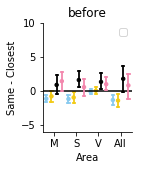

In [47]:
# Just make Fig 7E so we can try with different parameters
if True:
    plt.figure(figsize=(3.5, 2))
    gs = gridspec.GridSpec(1, 2)

    ### update these to the new colors
    pal = sns.color_palette(['#88caef', '#f2ca15', '#000000', '#f387ad'])

    ax = plt.subplot(gs[0, 0])
    kind = 'before'
    dc = ddist.loc[ddist['Kind'] == kind]
    with plt.rc_context({'lines.linewidth': 1}):
        sns.pointplot(data=dc, x='Area', y='Difference', hue='Group', join=False,
                      dodge=0.7, kind='point', ci=ci, capsize=0.1, scale=.75, palette=pal)
    ax.axhline(0, color='k')
    sns.despine()
    ax.set_ylabel('Same - '+ mode)
    ax.set_title(kind)
    ax.legend('')
    ax.set_xticklabels(['M', 'S', 'V', 'All'])
    ax.set_ylim([-6, 10])
    #ax.legend(ncol=4)

    save_path = os.path.join(fig_save_dir, 'trajectory-summary-transposed-' + mode + '.pdf')
    plt.savefig(save_path)

In [48]:
from copy import deepcopy

In [49]:
for test in [True, False, 'all']:
    for shuffle in [False, 'circ']:
        o = 0
        p = 0
        d = 0
        for dataset_id in dataset_ids:
            np.random.seed(seed)

            # Fit the classifier/basis using all sources (using PLSRegression)
            # The point of this panel is to compare train/test on the three different epochs
            # Obviously training happens on training trials vs. testing trials even if the
            # train and test epochs are the same.
            model = classifier.ClassifierModel(datasets[dataset_id], test_epoch,
                                               seed=seed,
                                               shuffle=shuffle)

            # Process all trials (vs. just "go" or something)
            trial_idx = np.arange(len(model.behavior.trial_types))
            
            # Use just "go" trials instead?
            #trial_idx = np.where(model.behavior.trial_types == 3)[0]

            # Get ground truth spout positions
            spout_positions = model.behavior.spout_positions - 1
            
            # Use most-licked pre-odor spout instead?
            #lut = np.array([0, 2, 3])
            #spout_positions = lut[np.argmax(model.favored_spout,1)]

            # Get all second trials
            second_trials = np.where(
                model.behavior.ind_within_block == 1)[0]
            if test or test == 'all':
                second_trials = trial_idx # test by using ALL trials
            #print(len(second_trials), 'all second trials')

            # Get the old spout
            same_labels = deepcopy(spout_positions)
            old_spout_positions = deepcopy(spout_positions)
            for pos in range(len(spout_positions)):
                rolled_pos = deepcopy(spout_positions)
                while rolled_pos[pos] == spout_positions[pos]:
                    rolled_pos = np.roll(rolled_pos, 1)
                old_spout_positions[pos] = rolled_pos[pos]

            # Test by using current spout locations
            if test and test != 'all':
                old_spout_positions = spout_positions
            
            # Check spout positions are correct
            assert np.sum(np.unique(old_spout_positions) - [0, 2, 3]) == 0

            # Get trials where pre-reward licks are mostly towards the active spout
            v = [model.behavior.get_on_target_licks(trial,
                 frame_range=[model.odor_on, model.reward_on],
                 target_spout=old_spout_positions[trial]+1)
                 for trial in second_trials]
            good_trials = second_trials[
                np.where(np.array(v) > classifier.DEFAULT_CLEAN_THRESHOLD)[0]]
            trial_idx = np.intersect1d(trial_idx, good_trials)

            # We can't compute AUC (and predict fails) with only 1 trial
            # so evaluate on a few more trials and then throw away those predictions
            buff = [1, 2, 3]
            preds, _ = model.predict(list(trial_idx) + buff)
            preds = preds[:len(trial_idx)]
            for pred, trial in zip(preds, trial_idx):
                curr_spout = spout_positions[trial]
                old_spout = old_spout_positions[trial]
                d += 1
                if pred == old_spout:
                    o += 1
                if pred == curr_spout:
                    p += 1
        if test:
            print('All trials (where selective for current spout)')
        elif test != 'all':
            print('2nd trials (where selective for old spout)')
        elif test == 'all':
            print('ALL trials (where selective for old spout)')
        if d > 0:
            print(shuffle, '(% correct old):', round(o/d*100,2),
                  '(% correct curr):', round(p/d*100,2), ' n =', d, 'trials')

/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1401 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:390: UserWarning: Quantifying prediction accuracy using action!
  warnings.warn('Quantifying prediction accuracy using action!')
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1240 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1084 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))
/home/deisseroth/Code/COSMOS/cosmos/traces/classifier_utils.py:265: UserWarning: 1054 sources found. Using only top 500
  'Using only top ' + str(max_cells_to_use))


All trials (where selective for current spout)
False (% correct old): 37.61 (% correct curr): 37.61  n = 351 trials
All trials (where selective for current spout)
circ (% correct old): 25.17 (% correct curr): 25.17  n = 143 trials


/home/deisseroth/venv2/lib/python3.6/site-packages/sklearn/metrics/ranking.py:571: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/deisseroth/venv2/lib/python3.6/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


2nd trials (where selective for old spout)
False (% correct old): 28.57 (% correct curr): 14.29  n = 7 trials
2nd trials (where selective for old spout)
circ (% correct old): 14.29 (% correct curr): 28.57  n = 7 trials
All trials (where selective for current spout)
False (% correct old): 25.0 (% correct curr): 26.67  n = 60 trials
All trials (where selective for current spout)
circ (% correct old): 24.18 (% correct curr): 22.22  n = 153 trials


All trials (where selective for current spout) False (% correct old): 37.61 (% correct curr): 37.61  n = 351 trials

All trials (where selective for current spout) circ (% correct old): 25.17 (% correct curr): 25.17  n = 143 trials

2nd trials (where selective for old spout) False (% correct old): 28.57 (% correct curr): 14.29  n = 7 trials

2nd trials (where selective for old spout) circ (% correct old): 14.29 (% correct curr): 28.57  n = 7 trials

All trials (where selective for current spout) False (% correct old): 25.0 (% correct curr): 26.67  n = 60 trials

All trials (where selective for current spout) circ (% correct old): 24.18 (% correct curr): 22.22  n = 153 trials

VIS all 7.81321e-03 ** ; ttest_rel (fdr_bh post-hoc)
VIS MO 7.10098e-02 ns ; ttest_rel (fdr_bh post-hoc)
VIS SSp 5.37507e-02 ns ; ttest_rel (fdr_bh post-hoc)


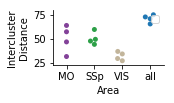

In [50]:
plt.figure(figsize=(2, 1))
pal = sns.color_palette(['#834299', '#2da048', '#c2b59b', '#1f77b4'])
pd_area = pd.DataFrame.from_dict(dict(area_dist))
pd_areas = pd.melt(pd_area, var_name='Area', value_name='Intercluster Distance')
with plt.rc_context({'lines.linewidth': 1}):
    sns.swarmplot(data=pd_areas, x='Area', y='Intercluster Distance', hue='Area', palette=pal)
plt.ylabel('Intercluster\nDistance')
plt.legend('')
sns.despine()

comps = []
ps = []
#for a, area in enumerate(area_dist.keys()):
a = 0
area = 'VIS'
for b, area_ in enumerate(area_dist.keys()):
    if (area != area_):# and (a > b):
        p = stats.ttest_rel(np.array(area_dist[area]), np.array(area_dist[area_]))[1]
        comps.append(area + ' ' + area_)
        ps.append(p)

reject, pvals, _, _ = mt.multipletests(ps, alpha=alpha, method='fdr_bh')
for comp, p in zip(comps, pvals):
    s = get_stars(p)
    print(comp, '{0:2.5e}'.format(p), s + ' ; ttest_rel (fdr_bh post-hoc)')
save_path = os.path.join(fig_save_dir, 'cluster-separation.pdf')
plt.savefig(save_path)

In [51]:
#VIS all 5.37507e-02 ns ; ttest_rel (fdr_bh post-hoc)
#VIS MO 7.10098e-02 ns ; ttest_rel (fdr_bh post-hoc)
#VIS SSp 5.37507e-02 ns ; ttest_rel (fdr_bh post-hoc)

In [52]:
# DEBUGGING CODE TO PLOT LICKS ON SECOND TRIALS
#tr = np.where(model.behavior.trial_types == 2)[0]
#second_trials = np.where(
#    model.behavior.ind_within_block < 2)[0]
#tr = second_trials#np.intersect1d(tr, second_trials)
#model.behavior.plot_lick_times(alt_colors=True, trials_subset=second_trials, markersize=5)

In [53]:
areas = ['all', 'MO', 'SSp', 'VIS']

In [54]:
alt = 'two-sided'
print_counts = True

for group in groups:
    print('>>>>>>>>', group)
    da = ddist.loc[ddist['Group'] == group]
    for area in ['all']:
        dc = da.loc[da['Area'] == area]
        b = np.array(dc.loc[dc['Kind'] == 'before']['Difference'])
        d = np.array(dc.loc[dc['Kind'] == 'during']['Difference'])
        a = np.array(dc.loc[dc['Kind'] == 'after']['Difference'])
        
        # Check stuff lines up before we run a paired test
        bm = np.array(dc.loc[dc['Kind'] == 'before']['Mouse'])
        dm = np.array(dc.loc[dc['Kind'] == 'during']['Mouse'])
        am = np.array(dc.loc[dc['Kind'] == 'after']['Mouse'])
        assert np.all(bm == dm)
        assert np.all(bm == am)

        # Count the number of trials from each mouse/type
        if print_counts:
            nm = defaultdict(int)
            x = dc['Mouse']
            for mouse in x:
                nm[mouse] += 1
            print('trials of each trial type (b, d, a):', len(b), len(d), len(a),
                  '\ntrials per mouse: ', list(nm.values()), '\n')
            print_counts = False

        print('---')
        labels = ['pre vs odor', 'pre vs after', 'odor vs after']
        comps = [[b, d], [b, a], [d, a]]
        ps = []
        print('N comparisons =', len(comps))
        # This is an unpaired test betwen the difference distributions of the different types
        for vecs in comps:
            p = stats.wilcoxon(vecs[0], vecs[1], alternative=alt).pvalue
            ps.append(p)

        reject, pvals, _, _ = mt.multipletests(ps, alpha=alpha, method='fdr_bh')
        for comp, p in zip(labels, pvals):
            s = get_stars(p)
            print(area, comp, '{0:2.5e}'.format(p), s + ' ; wilcoxon (fdr_bh post-hoc)\n')

>>>>>>>> Go trials
trials of each trial type (b, d, a): 223 223 223 
trials per mouse:  [183, 201, 159, 126] 

---
N comparisons = 3
all pre vs odor 6.13353e-09 **** ; wilcoxon (fdr_bh post-hoc)

all pre vs after 3.28050e-24 **** ; wilcoxon (fdr_bh post-hoc)

all odor vs after 5.79170e-18 **** ; wilcoxon (fdr_bh post-hoc)

>>>>>>>> No go trials
---
N comparisons = 3
all pre vs odor 1.72485e-02 * ; wilcoxon (fdr_bh post-hoc)

all pre vs after 1.46102e-03 ** ; wilcoxon (fdr_bh post-hoc)

all odor vs after 1.25152e-02 * ; wilcoxon (fdr_bh post-hoc)

>>>>>>>> Incorrect go trials
---
N comparisons = 3
all pre vs odor 3.78315e-02 * ; wilcoxon (fdr_bh post-hoc)

all pre vs after 1.82900e-03 ** ; wilcoxon (fdr_bh post-hoc)

all odor vs after 1.50450e-01 ns ; wilcoxon (fdr_bh post-hoc)

>>>>>>>> 2nd trials
---
N comparisons = 3
all pre vs odor 6.78235e-01 ns ; wilcoxon (fdr_bh post-hoc)

all pre vs after 6.78235e-01 ns ; wilcoxon (fdr_bh post-hoc)

all odor vs after 2.86523e-01 ns ; wilcoxon (f

In [55]:
alt = 'two-sided'
print_counts = True

for kind in kinds:
    print(kind)
    da = ddist.loc[ddist['Kind'] == kind]
    for area in areas:
        dc = da.loc[da['Area'] == area]
        g = np.array(dc.loc[dc['Group'] == 'Go trials']['Difference'])
        n = np.array(dc.loc[dc['Group'] == 'No go trials']['Difference'])
        i = np.array(dc.loc[dc['Group'] == 'Incorrect go trials']['Difference'])
        s = np.array(dc.loc[dc['Group'] == '2nd trials']['Difference'])

        # Count the number of trials from each mouse/type
        if print_counts:
            nm = defaultdict(int)
            x = dc['Mouse']
            for mouse in x:
                nm[mouse] += 1
            print('trials of each trial type (g, n, i, s):', len(g), len(n), len(i), len(s),
                  '\ntrials per mouse: ', list(nm.values()), '\n')
            print_counts = False

        print('---')
        #labels = ['go vs no', 'go vs wrong', 'no vs wrong', 'go vs 2nd', 'wrong vs 2nd', 'no vs 2nd']
        labels = ['go vs no', 'go vs wrong', 'go vs 2nd']
        #comps = [[g, n], [g, i], [n, i], [g, s], [s, s], [n, s]]
        comps = [[g, n], [g, i], [g, s]]
        ps = []
        print('N comparisons =', len(comps))
        # This is an unpaired test betwen the difference distributions of the different types
        for vecs in comps:
            p = stats.mannwhitneyu(vecs[0], vecs[1], alternative=alt).pvalue
            ps.append(p)

        reject, pvals, _, _ = mt.multipletests(ps, alpha=alpha, method='fdr_bh')
        for comp, p in zip(labels, pvals):
            s = get_stars(p)
            print(area, comp, '{0:2.5e}'.format(p), s + ' ; mann-whitney U (fdr_bh post-hoc)\n')

before
trials of each trial type (g, n, i, s): 223 110 29 37 
trials per mouse:  [104, 132, 89, 74] 

---
N comparisons = 3
all go vs no 8.11089e-01 ns ; mann-whitney U (fdr_bh post-hoc)

all go vs wrong 4.84846e-04 *** ; mann-whitney U (fdr_bh post-hoc)

all go vs 2nd 8.80957e-03 ** ; mann-whitney U (fdr_bh post-hoc)

---
N comparisons = 3
MO go vs no 4.01983e-01 ns ; mann-whitney U (fdr_bh post-hoc)

MO go vs wrong 7.00563e-04 *** ; mann-whitney U (fdr_bh post-hoc)

MO go vs 2nd 1.83511e-04 *** ; mann-whitney U (fdr_bh post-hoc)

---
N comparisons = 3
SSp go vs no 4.54871e-01 ns ; mann-whitney U (fdr_bh post-hoc)

SSp go vs wrong 1.29330e-05 **** ; mann-whitney U (fdr_bh post-hoc)

SSp go vs 2nd 1.43772e-03 ** ; mann-whitney U (fdr_bh post-hoc)

---
N comparisons = 3
VIS go vs no 6.20184e-01 ns ; mann-whitney U (fdr_bh post-hoc)

VIS go vs wrong 8.90834e-03 ** ; mann-whitney U (fdr_bh post-hoc)

VIS go vs 2nd 3.04755e-02 * ; mann-whitney U (fdr_bh post-hoc)

during
---
N comparisons 

In [56]:
x =  [0.8, 0.9166666666666666, 1.0, 1.0, 1.0, 0.8999999999999999,
1.0, 0.888888888888889, 0.875, 1.0, 0.8333333333333334, 1.0, 0.7, 1.0, 1.0, 1.0, 0.8333333333333334, 0.8571428571428572,
1.0, 0.7777777777777778, 1.0, 1.0, 1.0, 0.9166666666666666, 1.0, 0.7999999999999999, 0.875, 1.0, 1.0,
0.25, 0.75, 0.7999999999999999, 0.7142857142857143, 1.0, 1.0, 0.6666666666666666, 1.0] 
print(len(x), np.round(np.mean(x),2))

37 0.9


In [57]:
x = [0.7, 0.75, 0.5555555555555556, 0.625, 0.7999999999999999, 0.7777777777777778,
0.875, 1.0, 0.6363636363636364, 0.8333333333333334, 0.8571428571428572, 0.5454545454545455, 0.6666666666666667, 0.8333333333333334, 0.8571428571428572, 0.8999999999999999, 0.75, 1.0,
1.0, 0.5384615384615384, 0.75, 1.0, 1.0, 0.7999999999999999, 0.26666666666666666, 0.7999999999999999, 0.33333333333333337, 0.8999999999999999, 0.7272727272727273,
0.6428571428571428, 0.7, 0.7142857142857143, 0.5, 0.5833333333333334, 0.6666666666666667, 0.6666666666666666, 0.7142857142857143] 
print(len(x), np.round(np.mean(x),2), np.round(np.std(x),2))

37 0.74 0.17


In [58]:
x = [0.625, 0.0, 0.5, 0.8333333333333334, 0.5, 0.6,
0.0, 0.0, 0.0, 1.0, 0.2857142857142857, 1.0, 0.5, 0.5454545454545455, 0.4285714285714286, 1.0, 0.0, 0,
 1.0, 0.0, 1.0, 0.8333333333333334, 1.0, 0.0, 1.0, 0.125, 0.19999999999999998, 1.0, 0.7777777777777778,
0.125, 0.75, 0.4444444444444445, 0.875, 0.5384615384615385, 0.4444444444444445, 0, 0.5454545454545455] 
print(len(x), np.round(np.mean(x),2), np.round(np.std(x),2))

37 0.5 0.38


## What does the trial before each test trial look like?

In [59]:
ns = defaultdict(lambda:defaultdict(list))
wt_models = {}
min_neurons = -1 # uses all neurons
for dataset_id in datasets.keys():
    # make a model exactly the same as in the measure_centroids
    # we need that so we get training_trials
    region_neurons = classifier.get_region_neurons(
        datasets[dataset_id].cosmos_traces,
        datasets[dataset_id].p_ordering, 'all', min_neurons)

    model = classifier.ClassifierModel(datasets[dataset_id], 'pre odor all',
                                       cells_to_use=region_neurons)

    trial_lists = defaultdict(list)
    for trial_mode in ['good', 'nogo', 'bad', 'explore']:
        for trial in range(datasets[dataset_id].behavior.ntrials):
            if trial in model.training_trials:
                continue
            selectivity = model.behavior.get_on_target_licks(trial)
            tt = model.behavior.trial_types[trial] 
            if trial_mode is 'good':
                # Skip trials with low lick selectivity
                if (selectivity < good_cutoff):
                    continue
                # Only keep GO trials
                if tt != 3:
                    continue
            elif trial_mode is 'bad':
                # Skip trials if lick selectivity is too high
                if (selectivity > bad_cutoff):
                    continue
                # Only keep GO trials
                if tt != 3:
                    continue
            elif trial_mode is 'nogo':
                # Only keep NO GO trials
                if tt != 4:
                    continue
            elif trial_mode is 'explore':
                # Only keep EXPLORE trials
                if tt != 2:
                    continue

            # Get rid of any trials where there are licks during the ITI
            if trial in model.pre_lick_trials:
                continue

            trial_lists[trial_mode].append(trial)
    ns[dataset_id] = trial_lists
    wt_models[dataset_id] = model

# What trials are before each trial evaluated
trial_comp = pd.DataFrame()
for mode in trial_lists.keys():
    for key in mouse_colors_dict.keys():
        print(mode, mouse_colors_dict[key][1], len(ns[key][mode]))
        model = wt_models[key]
        n = ns[key]
        types = [0, 0, 0, 0] # good, bad, nogo, explore
        for trial in n[mode]:
            t = trial - 1
            x = False
            
            # Training trials are 'good' go trials by definition
            for k, o in zip([n['good'], model.training_trials, n['bad'], n['nogo'], n['explore']],
                            [0, 0, 1, 2, 3]):
                if t in k:
                    if x:
                        print('This is not possible')
                    types[o] += 1
                    x = True
        vec = np.round(np.array(types)/np.sum(types), 2)
        for idx, kind in enumerate(['good', 'bad' , 'nogo', 'explore']):
            vd = {'Mouse': key, 'This': mode, 'Previous': kind, 'Fraction': vec[idx]}
            trial_comp = trial_comp.append(vd, ignore_index=True)

good A 67
good B 53
good C 42
good D 61
nogo A 37
nogo B 22
nogo C 20
nogo D 31
bad A 40
bad B 13
bad C 28
bad D 15
explore A 36
explore B 29
explore C 24
explore D 23


In [60]:
# DEBUGGING: used to check training trial list vs. John
#dataset_id = 19
#
#region_neurons = classifier.get_region_neurons(
#        datasets[dataset_id].cosmos_traces,
#        datasets[dataset_id].p_ordering, 'all', -1)
#model = classifier.ClassifierModel(datasets[dataset_id], 'pre odor all', cull_pre_odor_licks=True,
#                                   shuffle=False, cells_to_use=region_neurons, seed=22222)
#
#np.sort(model.training_trials)

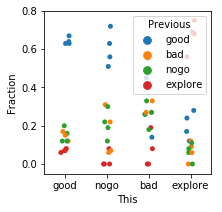

In [61]:
plt.figure(figsize=(3,3))
sns.stripplot(x='This', y='Fraction', hue='Previous', data=trial_comp)
save_path = os.path.join(fig_save_dir, 'previous-trials.pdf')
plt.savefig(save_path)

## Quantify temporal epochs of trajectories

In [62]:
areas = ['all', 'MO', 'SSp', 'VIS']
ci = 99 # This is what we use elsewhere in this analysis
pal = sns.color_palette(['#aed9f4', '#d3c729', '#000000', 'red'])
# return linewidth to default
sns.set_context(rc={"lines.linewidth": 1.5})

-----
4 comparisons
all before Go trials Wilcoxon fdr_bh posthoc p 1.27307e-07 ****
all before No go trials Wilcoxon fdr_bh posthoc p 7.47833e-05 ****
all before Incorrect go trials Wilcoxon fdr_bh posthoc p 4.66778e-02 *
all before 2nd trials Wilcoxon fdr_bh posthoc p 2.80735e-01 ns
-----
4 comparisons
MO before Go trials Wilcoxon fdr_bh posthoc p 3.00866e-06 ****
MO before No go trials Wilcoxon fdr_bh posthoc p 2.63497e-02 *
MO before Incorrect go trials Wilcoxon fdr_bh posthoc p 6.44891e-02 ns
MO before 2nd trials Wilcoxon fdr_bh posthoc p 2.63497e-02 *
-----
4 comparisons
SSp before Go trials Wilcoxon fdr_bh posthoc p 1.14438e-07 ****
SSp before No go trials Wilcoxon fdr_bh posthoc p 4.52031e-03 **
SSp before Incorrect go trials Wilcoxon fdr_bh posthoc p 4.52031e-03 **
SSp before 2nd trials Wilcoxon fdr_bh posthoc p 1.91905e-01 ns
-----
4 comparisons
VIS before Go trials Wilcoxon fdr_bh posthoc p 6.88445e-01 ns
VIS before No go trials Wilcoxon fdr_bh posthoc p 8.47461e-01 ns
VIS be

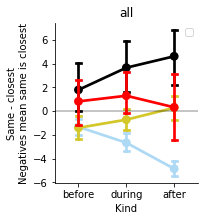

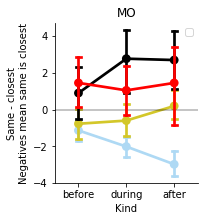

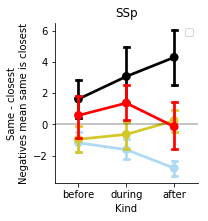

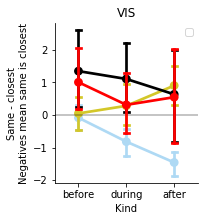

In [63]:
for area in areas:
    dc = ddist.loc[ddist['Area'] == area]
    plt.figure(figsize=(3, 3))
    sns.pointplot(data=dc, x='Kind', y='Difference', hue='Group',
                  kind='point', ci=ci, capsize=0.1, palette=pal)
    plt.axhline(0, color='k', alpha=.3)
    sns.despine()
    plt.legend('')
    plt.ylabel('Same - closest\nNegatives mean same is closest')
    plt.tight_layout()
    plt.title(area)

for area in areas:
    print('-----')
    pa = pdict.loc[pdict['Area'] == area]
    pdx = pa.to_dict()

    ps = list(pdx['Wilcoxon p'].values())
    pk = list(pdx['Wilcoxon p'].keys())
    
    # Only use the first 4 (corresponding to just BEFORE)
    reject, ps, _, _ = mt.multipletests(ps[:4], alpha=alpha, method='fdr_bh')
    for key, val in zip(pk, ps):
        pa = pa.copy()
        pa.loc[key, 'Wilcoxon p'] = val
    
    # Instead of kinds
    print(len(ps), 'comparisons')
    for kind in ['before']:
        
        for group in groups:
            pc = pa.loc[(pa['Kind'] == kind) &
                        (pa['Group'] == group)]
            p = list(pc['Wilcoxon p'])[0] # 4 tests * 3 epochs per area
            print(area, kind, group, 'Wilcoxon fdr_bh posthoc p {0:2.5e}'.format(p), get_stars(p))
    plt.title(area)
    save_path = os.path.join(fig_save_dir, area +
                             'trajectory-epochs.pdf')
    plt.savefig(save_path)

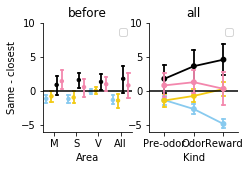

In [64]:
plt.figure(figsize=(3.5, 2))# 3,2
gs = gridspec.GridSpec(1, 2)

### update these to the new colors
pal = sns.color_palette(['#88caef', '#f2ca15', '#000000', '#f387ad'])

ax = plt.subplot(gs[0, 0])
kind = 'before'
dc = ddist.loc[ddist['Kind'] == kind]
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(data=dc, x='Area', y='Difference', hue='Group', join=False,
                  dodge=0.7, kind='point', ci=ci, capsize=0.1, scale=.75, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.set_ylabel('Same - closest')
ax.set_title(kind)
ax.legend('')
ax.set_xticklabels(['M', 'S', 'V', 'All'])
#ax.legend(ncol=4)


ax = plt.subplot(gs[0, 1], sharey=ax)
area = 'all'
dc = ddist.loc[ddist['Area'] == area]
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(data=dc, x='Kind', y='Difference', hue='Group',
                  kind='point', ci=ci, capsize=0.1, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.legend('')
ax.set_ylabel('')
ax.set_ylim([-6, 10])

ax.set_xticklabels(['Pre-odor', 'Odor', 'Reward'])
ax.set_title(area)

save_path = os.path.join(fig_save_dir, 'trajectory-summary-transposed.pdf')
plt.savefig(save_path)

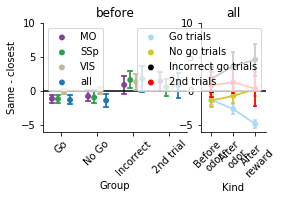

In [65]:
plt.figure(figsize=(4, 2))# sharey=True)
gs = gridspec.GridSpec(1, 3)

pal = sns.color_palette(['#834299', '#2da048', '#c2b59b', '#1f77b4'])
ax = plt.subplot(gs[0, :2])
kind = 'before'
dc = ddist.loc[ddist['Kind'] == kind]
#sns.boxplot(data=dc, ax=ax, x='Group', y='Difference', hue='Area', palette=pal)
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(data=dc, x='Group', y='Difference', hue='Area', join=False,
                  dodge=0.5, kind='point', ci=ci, capsize=0.1, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.set_ylabel('Same - closest')
ax.set_title(kind)
ax.legend()
ax.set_xticklabels(['Go', 'No Go', 'Incorrect', '2nd trial'],rotation=45)
#ax.legend(ncol=4)


ax = plt.subplot(gs[0, 2], sharey=ax)
area = 'all'
dc = ddist.loc[ddist['Area'] == area]
pal = sns.color_palette(['#aed9f4', '#d3c729', '#000000', 'red'])
with plt.rc_context({'lines.linewidth': 1}):
    sns.pointplot(data=dc, x='Kind', y='Difference', hue='Group',
                  kind='point', ci=ci, capsize=0.1, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.legend()
ax.set_ylabel('')
ax.set_ylim([-6, 10])

ax.set_xticklabels(['Before\nodor', 'After\nodor', 'After\nreward'],rotation=45)
ax.set_title(area)

save_path = os.path.join(fig_save_dir, area +
                         'trajectory-summary.pdf')
plt.savefig(save_path)

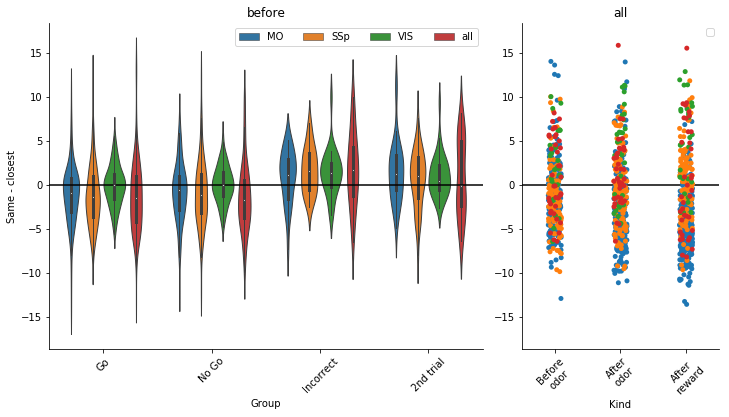

In [66]:
plt.figure(figsize=(12, 6))# sharey=True)
gs = gridspec.GridSpec(1, 3)

pal = sns.color_palette(['#834299', '#2da048', '#c2b59b', '#1f77b4'])
ax = plt.subplot(gs[0, :2])
kind = 'before'
dc = ddist.loc[ddist['Kind'] == kind]
#sns.boxplot(data=dc, ax=ax, x='Group', y='Difference', hue='Area', palette=pal)
with plt.rc_context({'lines.linewidth': 1}):
    sns.violinplot(data=dc, x='Group', y='Difference', hue='Area', #join=False,
                  dodge=0.5, size=2), #kind='point', ci=ci, capsize=0.1, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.set_ylabel('Same - closest')
ax.set_title(kind)
ax.legend('')
ax.set_xticklabels(['Go', 'No Go', 'Incorrect', '2nd trial'],rotation=45)
ax.legend(ncol=4)


ax = plt.subplot(gs[0, 2], sharey=ax)
area = 'all'
dc = ddist.loc[ddist['Area'] == area]
pal = sns.color_palette(['#aed9f4', '#d3c729', '#000000', 'red'])
with plt.rc_context({'lines.linewidth': 1}):
    sns.stripplot(data=dc, x='Kind', y='Difference', hue='Group')#,
                  #kind='point', ci=ci, capsize=0.1, palette=pal)
ax.axhline(0, color='k')
sns.despine()
ax.legend('')
ax.set_ylabel('')
#ax.set_ylim([-6, 10])

ax.set_xticklabels(['Before\nodor', 'After\nodor', 'After\nreward'],rotation=45)
ax.set_title(area)

plt.savefig(save_path)

TAILED = two-sided
Using the best -1 sources per area (including all)
Go trials MO  n =  223  per spout:  [72, 76, 75] , p =  1.00289e-06 **** ; Wilcoxon (fdr_bh post-hoc)
Go trials SSp  n =  223  per spout:  [72, 76, 75] , p =  6.36535e-08 **** ; Wilcoxon (fdr_bh post-hoc)
Go trials VIS  n =  223  per spout:  [72, 76, 75] , p =  5.16333e-01 ns ; Wilcoxon (fdr_bh post-hoc)
Go trials all  n =  223  per spout:  [72, 76, 75] , p =  6.36535e-08 **** ; Wilcoxon (fdr_bh post-hoc)
No go trials MO  n =  110  per spout:  [44, 40, 26] , p =  2.39457e-02 * ; Wilcoxon (fdr_bh post-hoc)
No go trials SSp  n =  110  per spout:  [44, 40, 26] , p =  5.69398e-03 ** ; Wilcoxon (fdr_bh post-hoc)
No go trials VIS  n =  110  per spout:  [44, 40, 26] , p =  8.47461e-01 ns ; Wilcoxon (fdr_bh post-hoc)
No go trials all  n =  110  per spout:  [44, 40, 26] , p =  1.49567e-04 *** ; Wilcoxon (fdr_bh post-hoc)
Incorrect go trials MO  n =  29  per spout:  [9, 2, 18] , p =  6.44891e-02 ns ; Wilcoxon (fdr_bh post-hoc)

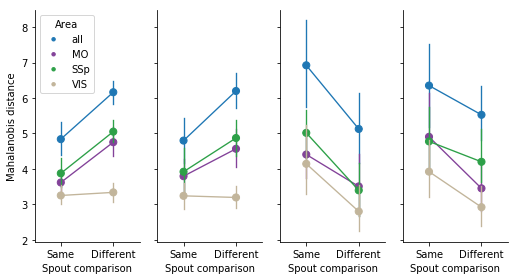

In [67]:
# Only use the 'before' distances
distances = all_distances['before']

# This is the default confidence interval size
ci = 99

# Do a ONE-sided Mann-Whitney test (not using default or TWO sided!)
#alt = 'less'
alt = 'two-sided'
print('TAILED =', alt)

# Make subpanels
pal = sns.color_palette(['#1f77b4', '#834299', '#2da048', '#c2b59b'])
print('Using the best', min_neurons, 'sources per area (including all)')
fig, axes = plt.subplots(figsize=(7.3, 4), ncols=4,
                         sharex=True, sharey=True)
sns.set_context(rc={"lines.linewidth": .75})
st = 0
for ax, trial_group in zip(axes, ['Go trials', 'No go trials', 'Incorrect go trials', '2nd trials']):
    dist_curr = distances.loc[distances['Trial group'] == trial_group]
    sns.pointplot(data=dist_curr, x='Spout comparison', y='Distance',
                  hue='Area', order=['Same', 'Different'],
                  dodge=0, height=2, ax=ax, ci=ci, palette=pal)
    sns.despine()
    plt.setp(ax.collections, sizes=[50])
    
    if st != 0:
        ax.get_legend().set_visible(False)
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Mahalanobis distance')
    st += 1

    # Compute stat for each area individually (pooling across mice)
    pvals = []
    n = []
    areas = np.unique(dist_curr['Area'])
    for area in areas:
        dist_area = dist_curr.loc[dist_curr['Area'] == area]
        same = np.array(dist_area.loc[
            dist_area['Spout comparison'] == 'Same']['Distance'])
        different = np.array(dist_area.loc[
            dist_area['Spout comparison'] == 'Different']['Distance'])
        p = stats.wilcoxon(same-different, alternative=alt)[1]
        pvals.append(p)
        n.append(len(same))
        
        # Count the number of trials towards each spout
        if area == 'all':
            ns = defaultdict(int)
            x = dist_area[dist_area['Spout comparison'] == 'Same']['Point identity']
            for spout in x:
                ns[spout] += 1

    # Correct the p values and display them
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    for r, area, nc, pval in zip(reject, areas, n, pvals):    
        s = get_stars(pval)
        print(trial_group, area, ' n = ', nc, ' per spout: ', list(ns.values()), ', p = ',
              '{0:2.5e}'.format(pval), s + ' ; Wilcoxon (fdr_bh post-hoc)')

# Save plot
plt.tight_layout()
save_path = os.path.join(fig_save_dir,
                         'initial-conditions.pdf')
plt.savefig(save_path)

Using the best -1 sources per area (including all)
TAILED = two-sided
alt = two-sided
Go trials mouse A  n =  67 , p =  3.01416e-02 * ; Wilcoxon (fdr_bh post-hoc)
Go trials mouse B  n =  53 , p =  3.27960e-01 ns ; Wilcoxon (fdr_bh post-hoc)
Go trials mouse C  n =  42 , p =  2.15317e-03 ** ; Wilcoxon (fdr_bh post-hoc)
Go trials mouse D  n =  61 , p =  3.67667e-05 **** ; Wilcoxon (fdr_bh post-hoc)
alt = two-sided
No go trials mouse A  n =  37 , p =  2.62686e-01 ns ; Wilcoxon (fdr_bh post-hoc)
No go trials mouse B  n =  22 , p =  2.62686e-01 ns ; Wilcoxon (fdr_bh post-hoc)
No go trials mouse C  n =  20 , p =  3.42604e-03 ** ; Wilcoxon (fdr_bh post-hoc)
No go trials mouse D  n =  31 , p =  2.41971e-03 ** ; Wilcoxon (fdr_bh post-hoc)
alt = two-sided
Incorrect go trials mouse A  n =  16 , p =  6.43678e-03 ** ; Wilcoxon (fdr_bh post-hoc)
Incorrect go trials mouse B  n =  3 , p =  2.17619e-01 ns ; Wilcoxon (fdr_bh post-hoc)
Incorrect go trials mouse C  n =  4 , p =  6.20278e-01 ns ; Wilcoxon (

/home/deisseroth/venv2/lib/python3.6/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


alt = two-sided
2nd trials mouse A  n =  12 , p =  4.15157e-01 ns ; Wilcoxon (fdr_bh post-hoc)
2nd trials mouse B  n =  11 , p =  9.29153e-01 ns ; Wilcoxon (fdr_bh post-hoc)
2nd trials mouse C  n =  8 , p =  4.15157e-01 ns ; Wilcoxon (fdr_bh post-hoc)
2nd trials mouse D  n =  6 , p =  9.29153e-01 ns ; Wilcoxon (fdr_bh post-hoc)


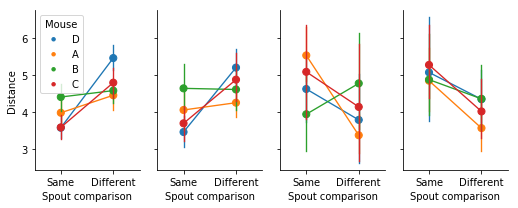

In [68]:
## Pool by MOUSE here and just put the stats in the text

# Make subpanels
print('Using the best', min_neurons, 'sources per area (including all)')
print('TAILED =', alt)
fig, axes = plt.subplots(figsize=(7.3, 3), ncols=4,
                         sharex=True, sharey=True)
sns.set_context(rc={"lines.linewidth": .75})
st = 0
for ax, trial_group in zip(axes, ['Go trials', 'No go trials', 'Incorrect go trials', '2nd trials']):
    dist_curr = distances.loc[distances['Trial group'] == trial_group]
    sns.pointplot(data=dist_curr, x='Spout comparison', y='Distance',
                  hue='Mouse', order=['Same', 'Different'],
                  dodge=0, height=2, ax=ax, ci=ci)
    sns.despine()
    plt.setp(ax.collections, sizes=[50])

    if st != 0:
        ax.get_legend().set_visible(False)
        ax.set_ylabel('')
    st += 1

    # Compute stat for each mouse individually (pooling across mice)
    pvals = []
    n = []
    mice = np.unique(dist_curr['Mouse'])
    for mouse in mice:
        dist_mouse = dist_curr.loc[(dist_curr['Mouse'] == mouse) & (dist_curr['Area'] == 'all')]
        same = np.array(dist_mouse.loc[
            dist_mouse['Spout comparison'] == 'Same']['Distance'])
        different = np.array(dist_mouse.loc[
            dist_mouse['Spout comparison'] == 'Different']['Distance'])
        p = stats.wilcoxon(same-different, alternative=alt)[1]
        pvals.append(p)
        n.append(len(same))

    # Correct the p values and display them
    reject, pvals, _, _ = mt.multipletests(pvals, alpha=alpha, method='fdr_bh')
    print('alt =', alt)
    for r, mouse, nc, pval in zip(reject, mice, n, pvals):    
        s = get_stars(pval)
        print(trial_group, 'mouse', mouse, ' n = ', nc, ', p = ',
              '{0:2.5e}'.format(pval), s + ' ; Wilcoxon (fdr_bh post-hoc)')

# Save plot
plt.tight_layout()
save_path = os.path.join(fig_save_dir,
                         'initial-conditions-by-mouse.pdf')
plt.savefig(save_path)

## Quantify variance explained by PCA and PLSRegression (6C)

1) var_explained(PCA) > var_explained(PLS), for each area
paired t-test pls vs pca  p = 4.2591779106839567e-10
2) var_explained(PLS_MO) > var_explained(PLS_OTHERS)
MO v MO; n mice = 4  p = nan
SSp v MO; n mice = 4  p = 0.844258
VIS v MO; n mice = 4  p = 0.221633
all v MO; n mice = 4  p = 0.39793


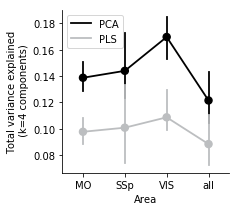

In [69]:
# 99% confidence intervals
min_neurons = -1
plt.figure(figsize=(3, 3))
sns.set_context(rc={"lines.linewidth": 1})
classifier.quantify_variance_explained(datasets, min_neurons, cull_pre_odor_licks=True)
save_path = os.path.join(fig_save_dir,
                         'variance-explained.pdf')
plt.savefig(save_path)

In [70]:
# return linewidth to default
sns.set_context(rc={"lines.linewidth": 1.5})

## Plot all of the trajectories (6A-C)

AREA all
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


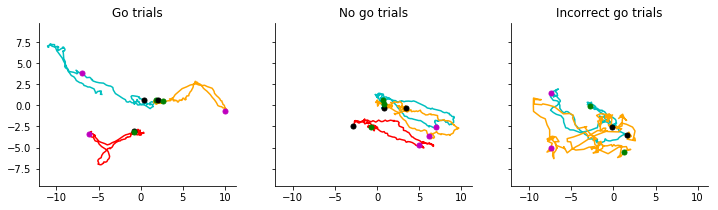

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


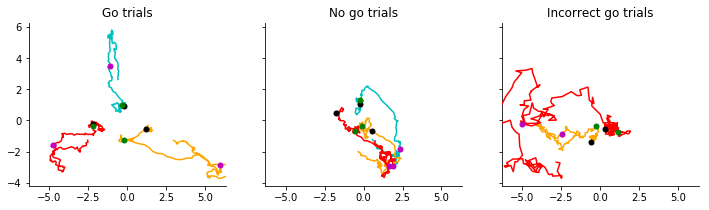

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


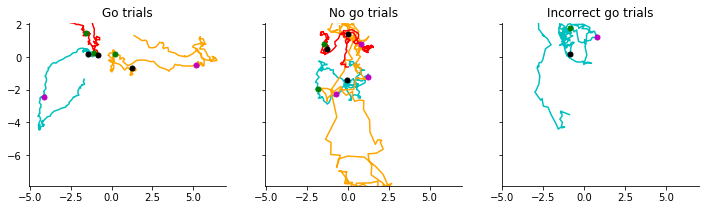

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


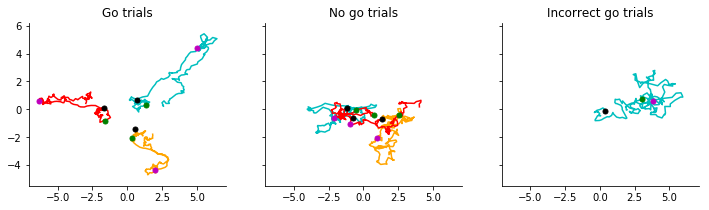

AREA MO
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


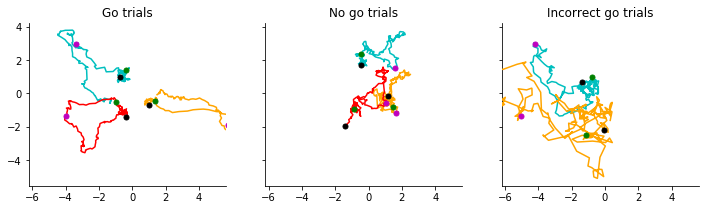

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


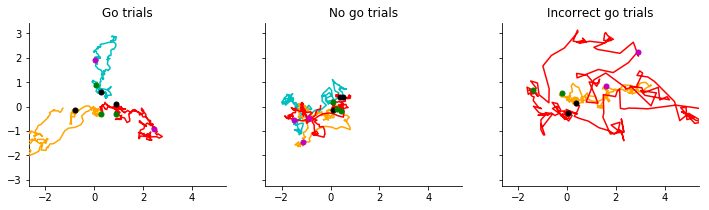

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


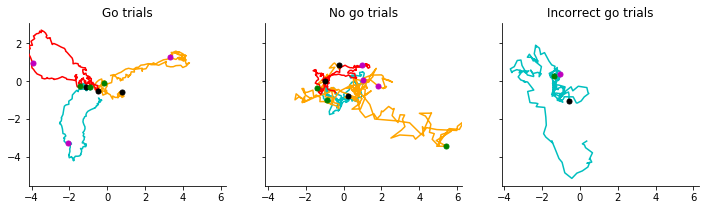

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


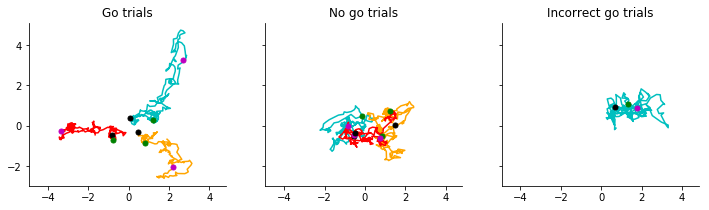

AREA SSp
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


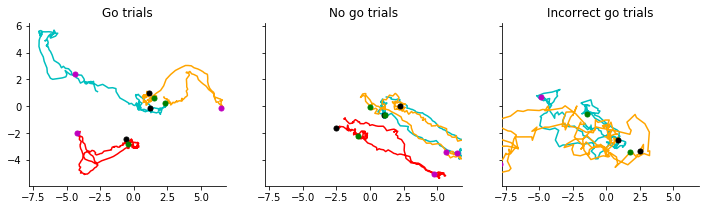

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


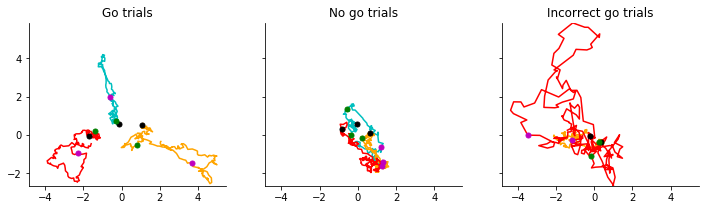

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


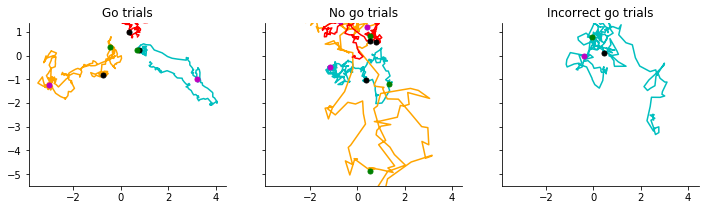

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


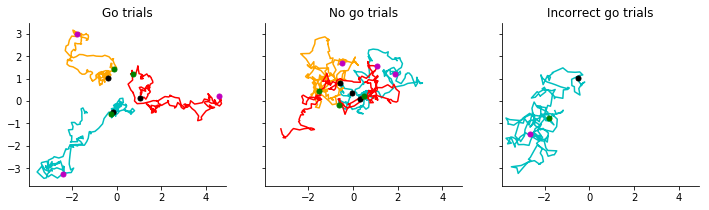

AREA VIS
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


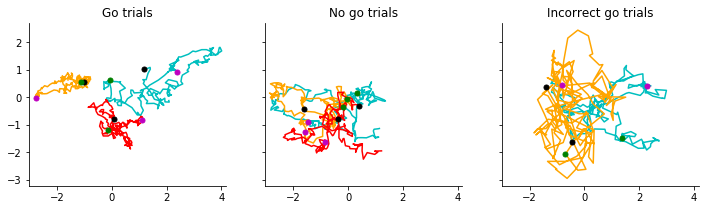

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


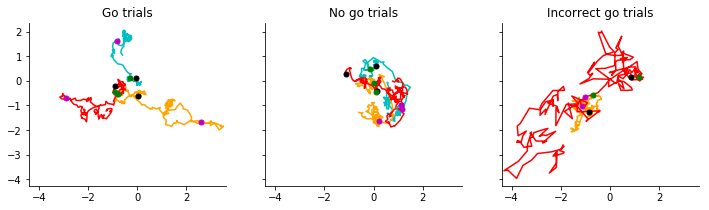

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


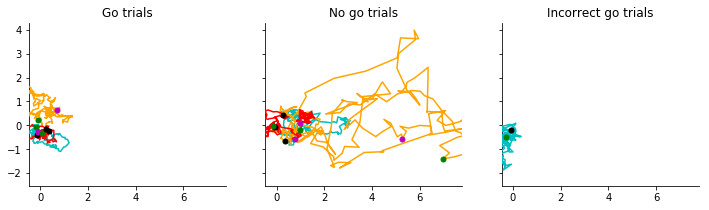

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


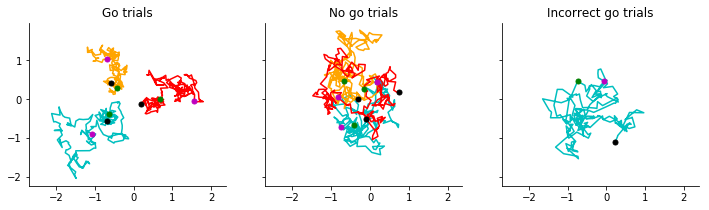

AREA all
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


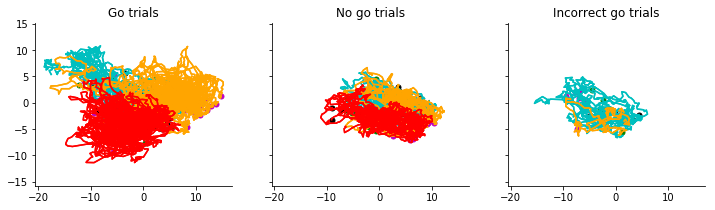

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


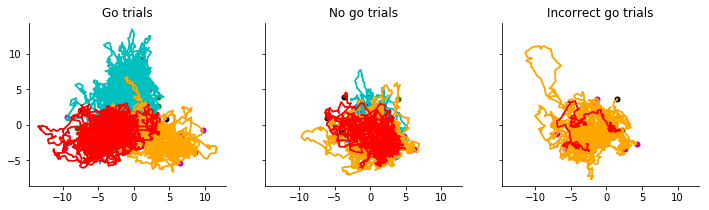

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


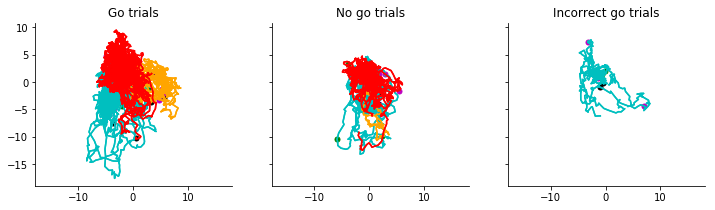

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


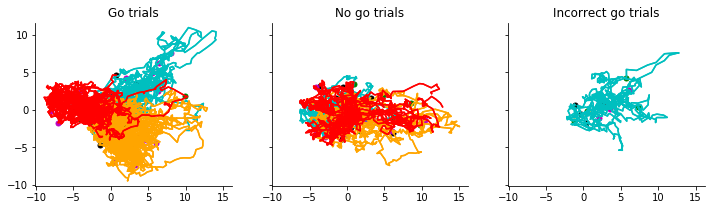

AREA MO
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


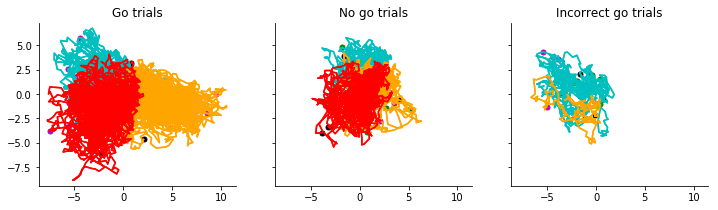

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


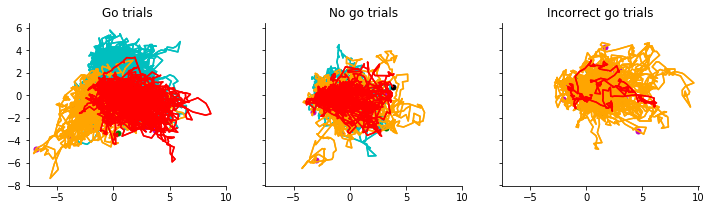

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


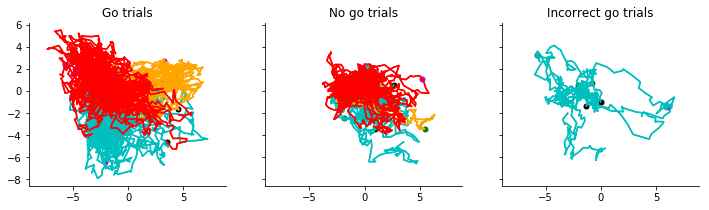

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


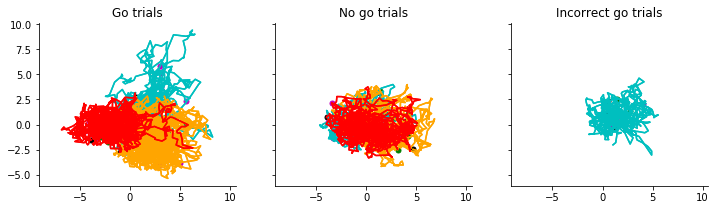

AREA SSp
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


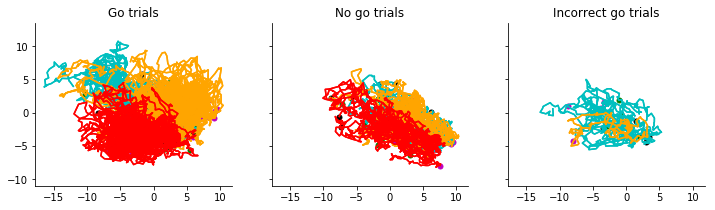

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


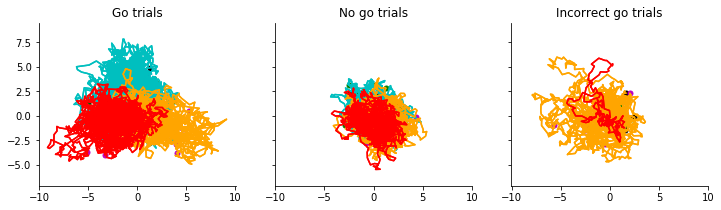

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


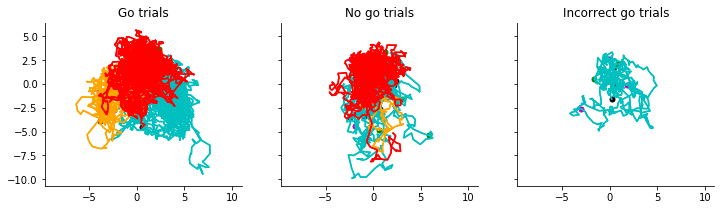

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


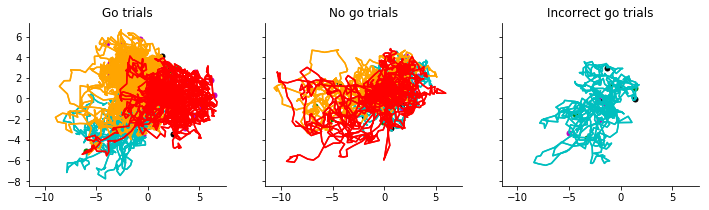

AREA VIS
dataset 19
Excluding training trials + those earlier than  0  within a block
n =  61 Go trials
n =  31 No go trials
n =  6 Incorrect go trials


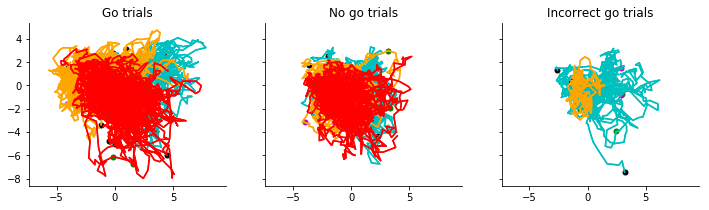

dataset 7
Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials


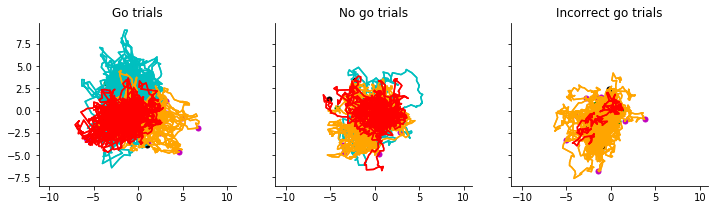

dataset 11
Excluding training trials + those earlier than  0  within a block
n =  53 Go trials
n =  22 No go trials
n =  3 Incorrect go trials


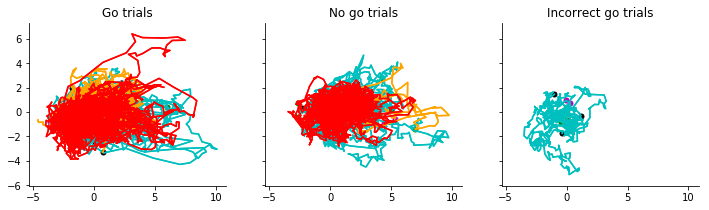

dataset 18
Excluding training trials + those earlier than  0  within a block
n =  42 Go trials
n =  20 No go trials
n =  4 Incorrect go trials


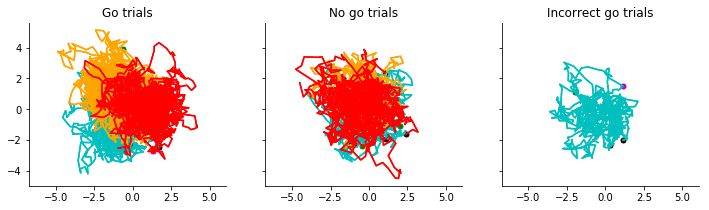

In [71]:
areas = ['all', 'MO', 'SSp', 'VIS']
epoch = 'all' # process full trajectories
min_block_trials = 0 # don't cull data based on block index
min_neurons = -1 # use all neurons (this value doesn't matter)
use_all = True # use all neurons for plotting trajectories rather than a good subset
clean_only = True # only average across selective trials

for trial_average in [True, False]:
    for area in areas:
        print('AREA', area)
        for dataset_id in datasets.keys():
            print('dataset', dataset_id)
            region_neurons = classifier.get_region_neurons(
                    datasets[dataset_id].cosmos_traces,
                    datasets[dataset_id].p_ordering, area,
                    min_neurons)

            if len(region_neurons) == 0:
                print('skipped', area, cdx)
                continue

            ### check by plotting atlas
            model = classifier.ClassifierModel(datasets[dataset_id], epoch, cells_to_use=region_neurons)
            save_path = os.path.join(fig_save_dir,
                             area + '-' + str(dataset_id) + '-average-' + str(trial_average) + '.pdf')
            l = model.plot_trajectories(min_block_trials=min_block_trials,
                                        plot_means=trial_average, clean_only=clean_only,
                                        save_path=save_path)


In [142]:
##### Plot trajectory movies
if True:
    area = 'all'
    dataset_id = 7
    clean_only = True
    save_path = None

    print('dataset', dataset_id)
    region_neurons = classifier.get_region_neurons(
            datasets[dataset_id].cosmos_traces,
            datasets[dataset_id].p_ordering, area,
            min_neurons)

    model = classifier.ClassifierModel(datasets[dataset_id], epoch, cells_to_use=region_neurons)
    traj_len = np.shape(datasets[dataset_id].Ct_n)[1]
    for trial_average, lims in zip([True, False], [[-7, 7], [-20, 20]]):
        print(' MOVIE, TRIAL AVERAGE =', trial_average)
        for frame in np.arange(2, traj_len):
            print(frame, end=' ')
            if trial_average == True:
                folder = 'movie-single-trial'
            else:
                folder = 'movie'
            save_path = os.path.join(fig_save_dir,
                             folder, area + '-' + str(dataset_id) + '-average-' +
                             str(trial_average) + str(frame) + '.png')
            l = model.plot_trajectories(min_block_trials=min_block_trials, stop_frame=frame,
                                        plot_means=trial_average, clean_only=clean_only,
                                        axes_lims=lims,
                                        save_path=save_path, close_fig=True)
            plt.close()

dataset 7
 MOVIE, TRIAL AVERAGE = True
2 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
3 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
4 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
5 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
6 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
7 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
8 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
9 Excluding trai

n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
63 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
64 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
65 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
66 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
67 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
68 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
69 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 I

n =  37 No go trials
n =  16 Incorrect go trials
123 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
124 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
125 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
126 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
127 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
128 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
129 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go

n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
183 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
184 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
185 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
186 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
187 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
188 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
189 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n 

n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
40 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
41 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
42 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
43 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
44 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
45 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
46 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 I

n =  16 Incorrect go trials
100 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
101 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
102 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
103 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
104 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
105 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
106 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
107 Excluding

n =  37 No go trials
n =  16 Incorrect go trials
160 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
161 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
162 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
163 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
164 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
165 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go trials
166 Excluding training trials + those earlier than  0  within a block
n =  67 Go trials
n =  37 No go trials
n =  16 Incorrect go

In [73]:
"""
model = classifier.ClassifierModel(datasets[dataset_id], epoch, cells_to_use=region_neurons)
"""

'\nmodel = classifier.ClassifierModel(datasets[dataset_id], epoch, cells_to_use=region_neurons)\n'

In [74]:
# Path is missing extension + frame number intentionally
"""
save_path = os.path.join(fig_save_dir,
                 'licks-movie', area + '-' + str(dataset_id) + '-average-' +
                 str(trial_average))
model.plot_lick_movie(datasets[dataset_id].cosmos_traces, save_path=save_path)
"""

"\nsave_path = os.path.join(fig_save_dir,\n                 'licks-movie', area + '-' + str(dataset_id) + '-average-' +\n                 str(trial_average))\nmodel.plot_lick_movie(datasets[dataset_id].cosmos_traces, save_path=save_path)\n"

## Train and evaluate prediction accuracy on different timeblocks pairwise (S8E-G)

In [98]:
# Just plot to make sure St aligns with Ct
do_double_check_spikes = False
if do_double_check_spikes:
    CT = datasets[dataset_id].cosmos_traces
    smoothS = gaussian_filter1d(CT.St, 1.5, axis=1, mode='constant')
    plt.figure(), plt.imshow(datasets[dataset_id].Ct_n[:50,:,0], aspect='auto')
    plt.figure(), plt.imshow(datasets[dataset_id].St_n[:50,:,0], aspect='auto')

    plt.figure(), plt.imshow(CT.Ct[:50,:,0], aspect='auto')
    plt.figure(), plt.imshow(smoothS[:50,:,0], aspect='auto')
    plt.figure(), plt.imshow(CT.St[:50,:,0], aspect='auto')

Training classifiers.
(1401,)
(1240,)
(1084,)
(1054,)
Testing classifiers.
dataset 19
32 25 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 7
58 49 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 11
24 13 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 18
24 8 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Plotting prediction matrices.
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d19_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d7_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d11_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d18_norm0.pdf
Saving to: /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_averaged_norm0.pdf
block_comparison
[[0.59373412 0.54537434 0.56712309]
 [0.52786074 0.68936821 0.55544071]
 [0.58432794 0.53555613 0.6481573 ]]


/home/deisseroth/venv2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


group by test, ttest-ind:
[[1.99433227e-02 1.96592688e-01]
 [1.12196180e-04 2.37825560e-03]
 [2.20152009e-02 2.05063321e-02]]
group by train, ttest-rel:
[[0.00816041 0.09891908]
 [0.00056015 0.00065801]
 [0.02832164 0.02130001]]
vs chance, ttest-1samp:
[[0.02400692 0.1763546  0.00984053]
 [0.37829901 0.00825359 0.17690933]
 [0.02437421 0.33908286 0.02437421]]
Plotting prediction matrices.
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d19_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d7_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d11_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_d18_norm1.pdf
Saving to: /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/all-block_auc_averaged_norm1.pdf
block_comparison
[[0.88601629 0.81268868 0.84812459]
 [0.64236514 0.83641283 0.67592205]
 [0.82502177 0.7554803  0.9110

/home/deisseroth/venv2/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


group by train, ttest-rel:
[[0.0096019  0.09296778]
 [0.00078611 0.00100287]
 [0.02965034 0.02187659]]
vs chance, ttest-1samp:
[[3.26400934e-05 5.45929511e-04 5.45929511e-04]
 [6.75654210e-03 1.00087580e-05 3.81044538e-03]
 [1.18974823e-04 7.01394669e-03 7.54989420e-04]]
Training classifiers.
(420,)
(238,)
(333,)
(319,)
Testing classifiers.
dataset 19
32 25 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 7
58 49 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 11
24 13 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
dataset 18
24 8 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
Plotting prediction matrices.
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/MO-block_auc_d19_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/MO-block_auc_d7_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/MO-block_auc_d11_norm0.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/MO-block_auc_d18_norm0.pdf
Saving to: /home/deisseroth/Dropbox/Projects/cosmo

vs chance, ttest-1samp:
[[0.05698174 0.05698174 0.05698174]
 [0.29910147 0.03408656 0.11955776]
 [0.07896948 0.76003316 0.1549759 ]]
Plotting prediction matrices.
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/PTLp-block_auc_d19_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/PTLp-block_auc_d7_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/PTLp-block_auc_d11_norm1.pdf
Saved to : /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/PTLp-block_auc_d18_norm1.pdf
Saving to: /home/deisseroth/Dropbox/Projects/cosmos/spout_prediction/PTLp-block_auc_averaged_norm1.pdf
block_comparison
[[0.85471963 0.83022403 0.83736343]
 [0.73589456 0.84169248 0.75263385]
 [0.83926488 0.78881854 0.87151779]]
group by test, ttest-ind:
[[0.00305905 0.11459253]
 [0.06063435 0.0625656 ]
 [0.1211372  0.02196981]]
group by train, ttest-rel:
[[0.06529738 0.20898494]
 [0.00103524 0.0051015 ]
 [0.17947152 0.06079005]]
vs chance, t

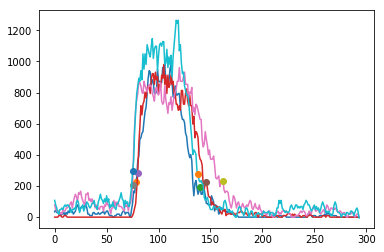

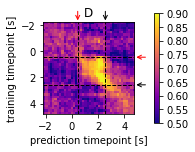

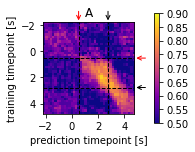

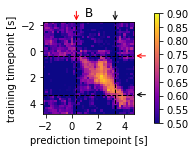

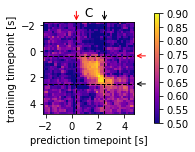

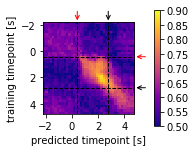

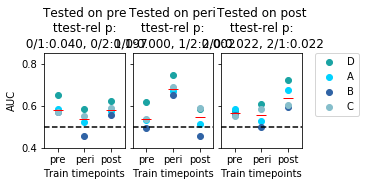

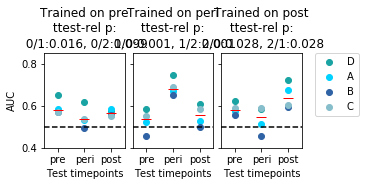

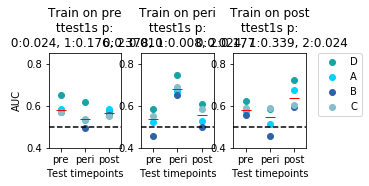

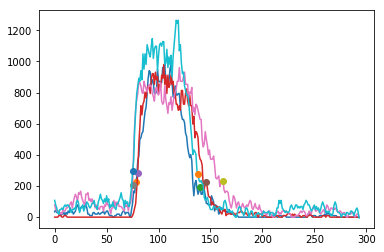

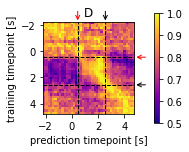

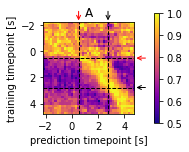

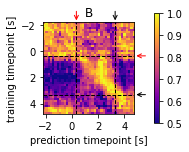

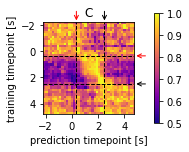

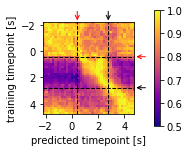

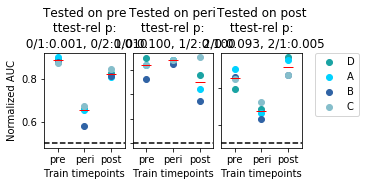

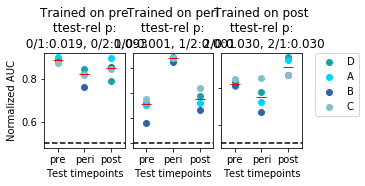

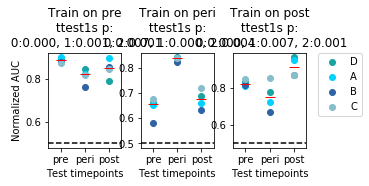

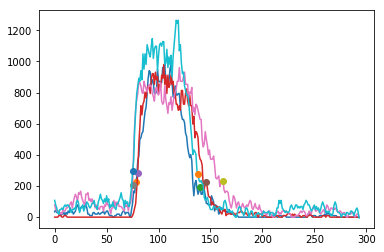

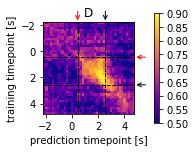

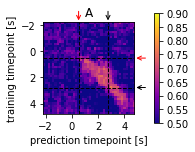

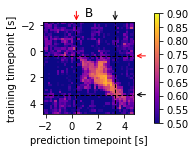

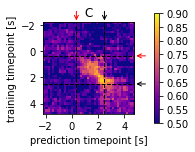

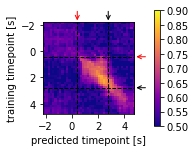

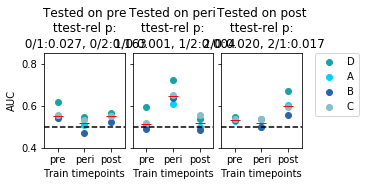

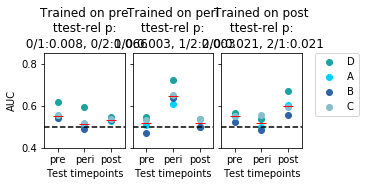

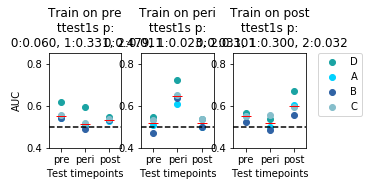

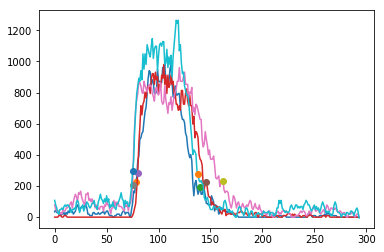

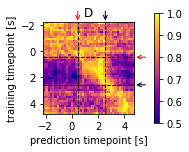

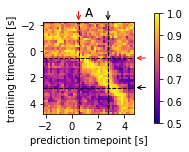

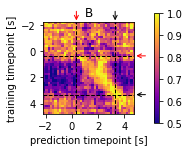

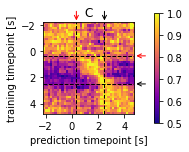

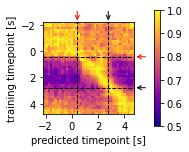

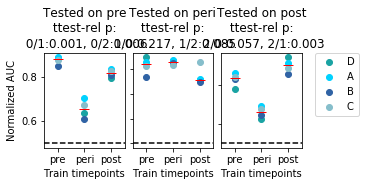

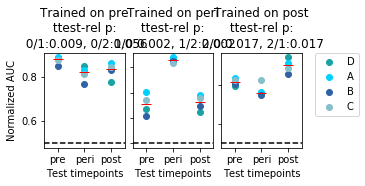

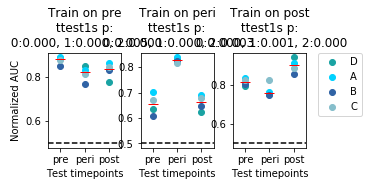

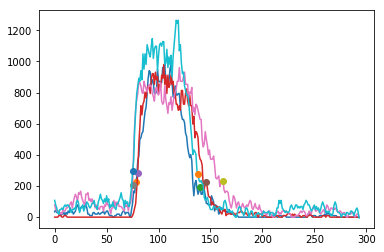

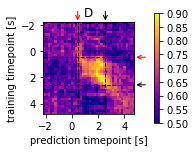

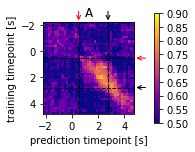

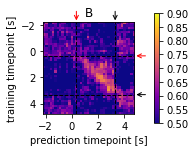

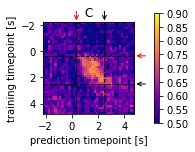

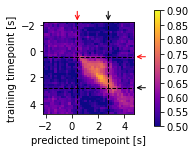

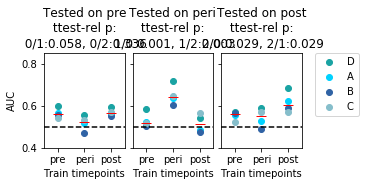

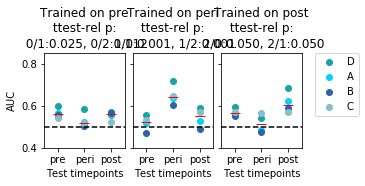

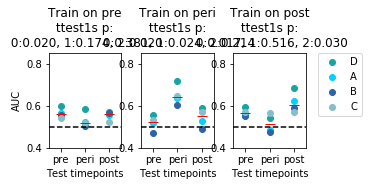

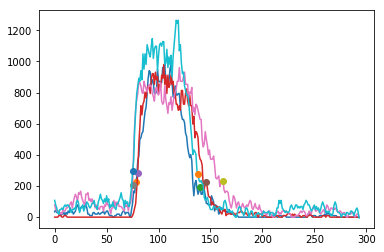

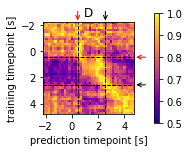

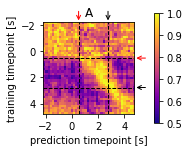

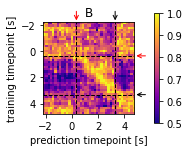

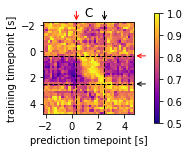

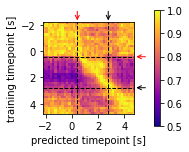

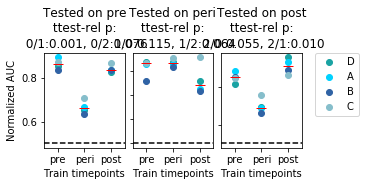

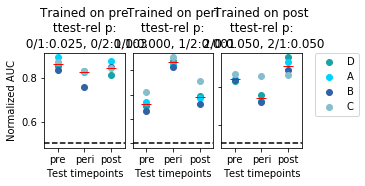

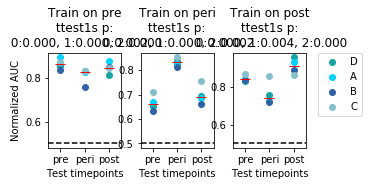

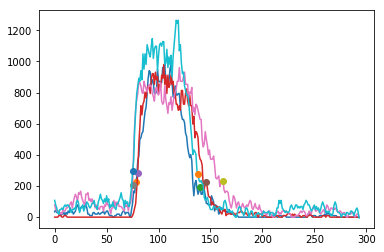

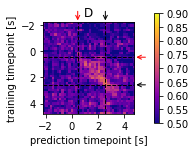

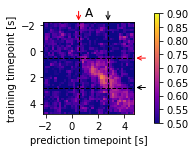

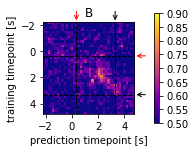

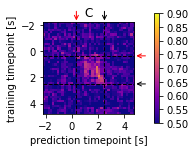

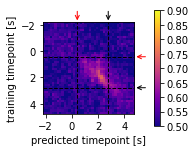

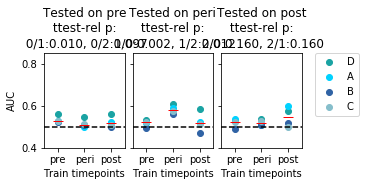

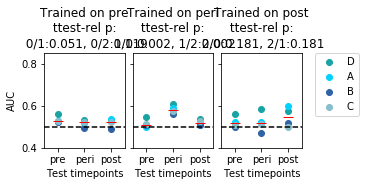

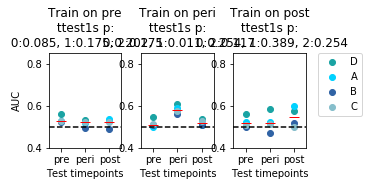

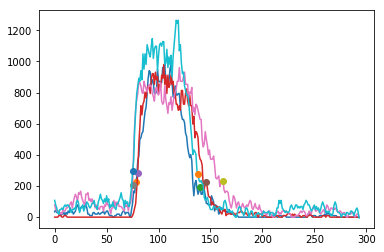

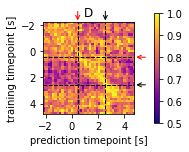

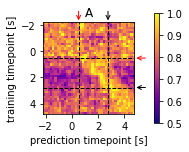

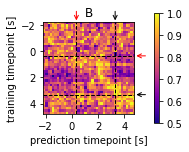

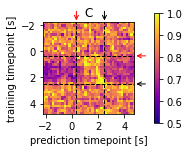

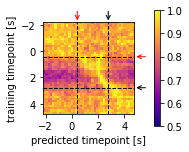

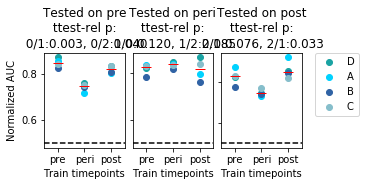

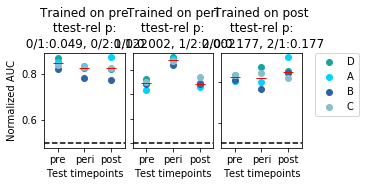

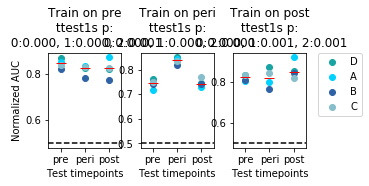

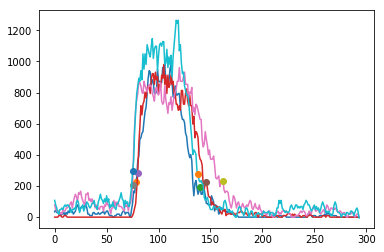

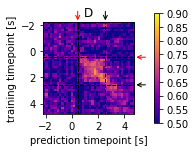

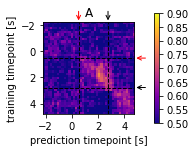

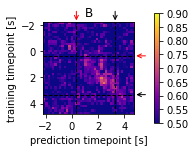

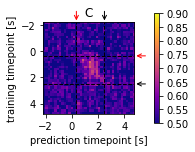

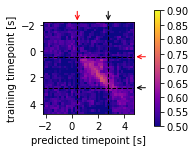

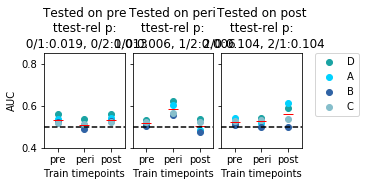

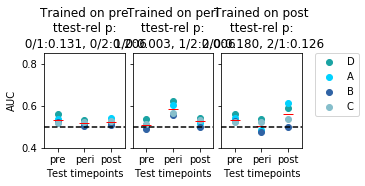

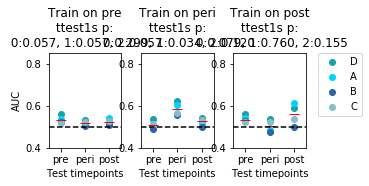

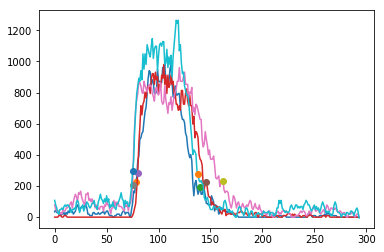

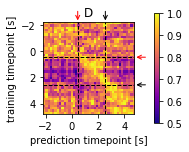

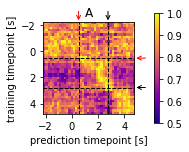

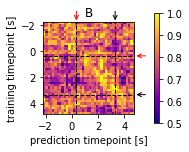

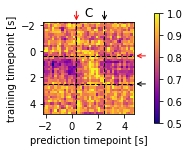

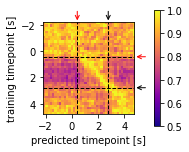

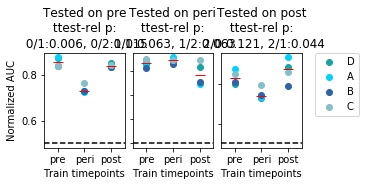

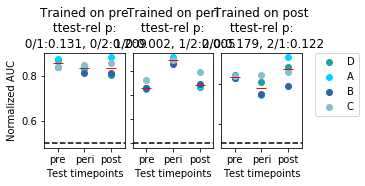

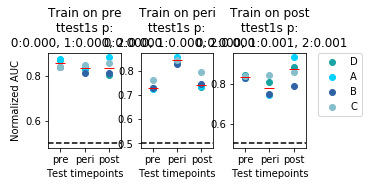

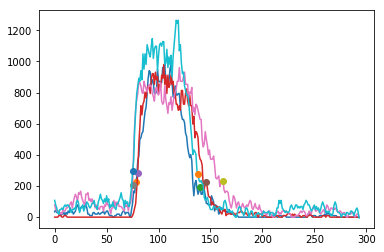

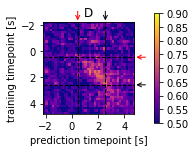

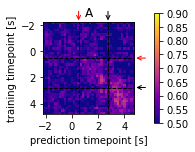

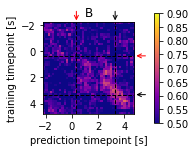

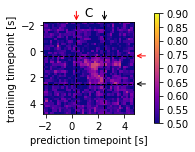

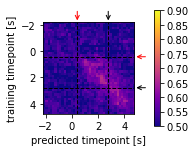

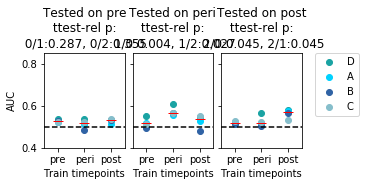

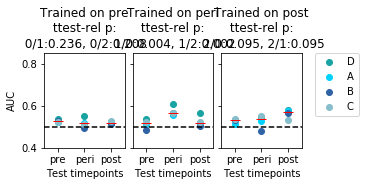

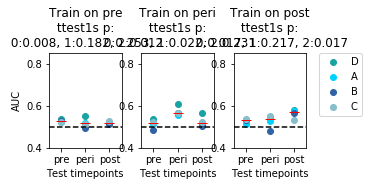

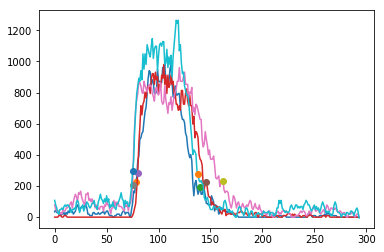

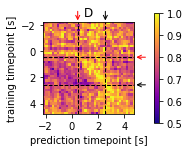

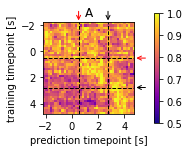

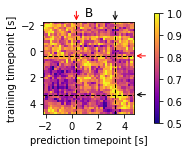

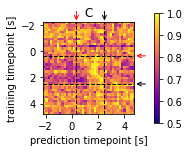

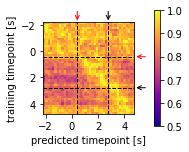

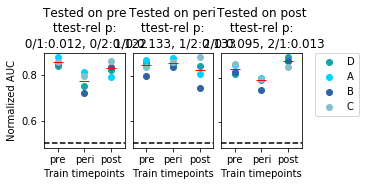

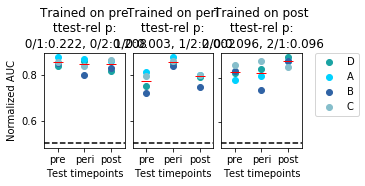

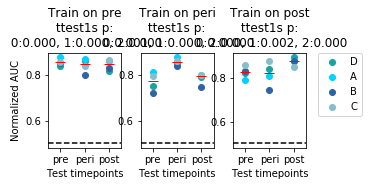

In [154]:
# Train, test, and plot figures comparing PLS bases computed on different time windows of neural data. 
use_spikes = True

for region in ['all', 'MO', 'SSp', 'VIS', 'PTLp', 'RSP']:
#for region in ['all']:
    (auc_mats, 
     all_time_basis, 
     time_bins) = classifier.generate_time_windowed_classification_basis(datasets,
                                                                         dataset_ids,
                                                                         region,
                                                                         use_spikes)

    for do_normalize in [0, 1]:
        classifier.summarize_time_windowed_classification_basis(datasets,
                                                                dataset_ids,
                                                                auc_mats,
                                                                time_bins,
                                                                all_time_basis,
                                                                region,
                                                                do_normalize,
                                                                mouse_colors_dict,
                                                                fig_save_dir=fig_save_dir,
                                                                do_plot_cosine_distance=False)